<a href="https://colab.research.google.com/github/namzhale/compilator/blob/main/PDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1 .Распаковка архива из Google Drive (с mol2 файлами лигандов)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Change to the directory containing the file
%cd /content/drive/MyDrive/PDB/PDB2.tar.gz

# Extract the tar.gz file
!tar -xzf PDB2.tar.gz

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 20] Not a directory: '/content/drive/MyDrive/PDB/PDB2.tar.gz'
/content
tar (child): PDB.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [ ]:
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 16.5 MB/s eta 0:00:00


In [ ]:

# Extract the tar.gz file
!tar -xzf /content/drive/MyDrive/PDB/PDB2.tar.gz

# **2. Чтение файла names для извлечения соответствия имя/id белка с pdb_id лиганда**

In [ ]:
import pandas as pd

# Открытие файла names.txt для чтения
with open('names.txt', 'r') as file:
    data = file.readlines()

# Разбиение строк на колонки с ограничением по максимальному количеству разделителей
rows = [row.strip().split(maxsplit=3) for row in data]

# Создание DataFrame и заполнение пропущенных значений
df = pd.DataFrame(rows, columns=['pdb_code', 'release_year', 'uniprot_id', 'protein_name'])
df = df.fillna('')

# Преобразование типов данных
df['release_year'] = df['release_year'].astype(int)



In [ ]:
df['pdb_code'] = df['pdb_code'].astype(str)

In [ ]:
df

pdb_code  release_year uniprot_id  \
0         6mu1          2018     P29994   
1         3t8s          2011     P29994   
2         1n4k          2002     P11881   
3         5urm          2017     O75643   
4         5urj          2017     O75643   
...        ...           ...        ...   
19438     1swi          1996     P03069   
19439     2lk1          2011     P52756   
19440     6eiz          2018     ------   
19441     2ly0          2013     Q6XT21   
19442     2lyw          2012     P30989   

                                            protein_name  
0           INOSITOL 1,4,5-TRISPHOSPHATE RECEPTOR TYPE 1  
1           INOSITOL 1,4,5-TRISPHOSPHATE RECEPTOR TYPE 1  
2           INOSITOL 1,4,5-TRISPHOSPHATE RECEPTOR TYPE 1  
3      U5 SMALL NUCLEAR RIBONUCLEOPROTEIN 200 KDA HEL...  
4      U5 SMALL NUCLEAR RIBONUCLEOPROTEIN 200 KDA HEL...  
...                                                  ...  
19438                                             GCN4P1  
19439                              RNA-BINDING PROTEIN 5  
19440                                            CC-HEX2  
19441                            MEMBRANE ION CHANNEL M2  
19442                        NEUROTENSIN RECEPTOR TYPE 1  

[19443 rows x 4 columns]

**Проверка размеров кластеров**

In [ ]:
protein_name_counts = df['uniprot_id'].value_counts(dropna=False)
print(protein_name_counts)

uniprot_id
P00918    428
------    354
P56817    344
P24941    255
O60885    202
         ... 
Q6VAB6      1
P39182      1
Q9UR30      1
P29295      1
P30989      1
Name: count, Length: 3890, dtype: int64


#**3. Чтение mol2 файлов и преобразование в smiles для лигандов исходя из полученного из предыдущего шага df**

In [ ]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AddHs, SanitizeMol

# Assuming you have 'pdb_code' column in your DataFrame
pdb_codes = df['pdb_code'].tolist()

# Initialize an empty list to store data
data = []

# Loop through each pdb_code
for pdb_code in pdb_codes:
    folder_path = os.path.join('v2020-other-PL', pdb_code)

    # Check if the folder exists
    if os.path.isdir(folder_path):
        # Find the mol2 file in the folder
        mol2_file = os.path.join(folder_path, f"{pdb_code}_ligand.mol2")

        # If mol2 file exists, read and add hydrogens
        if os.path.isfile(mol2_file):
            try:
                mol = Chem.MolFromMol2File(mol2_file)
                mol = AddHs(mol)  # Add explicit hydrogens
                SanitizeMol(mol)  # Sanitize the molecule

                # Extract SMILES string from the molecule
                smiles = Chem.MolToSmiles(mol)

                # Append the data to the list
                data.append([pdb_code, smiles])
            except Exception as e:
                print(f"Error processing {pdb_code}: {e}")
                data.append([pdb_code, None])
    else:
        # If the folder doesn't exist, append None values
        data.append([pdb_code, None])

# Create a new DataFrame from the data list
new_df = pd.DataFrame(data, columns=['pdb_code', 'smiles'])

# Merge the new DataFrame with the original DataFrame
merged_df = pd.merge(df, new_df, on='pdb_code', how='left')

[13:41:23] Explicit valence for atom # 25 C, 5, is greater than permitted


Error processing 3cst: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:41:23] sanitise [13:41:23] 3cst_ligand: [13:41:23] 2j7w_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[13:41:24] Warning - O.co2 with degree >1.


Error processing 3qlb: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:41:26] 2rk7_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[13:41:27] Can't kekulize mol.  Unkekulized atoms: 3 4 5 15 17
[13:41:27] sanitise [13:41:27] 5tyk_ligand: [13:41:27] 2hwg_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[13:41:27] 1t5a_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


Error processing 5tyk: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:41:27] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 8 9 10
[13:41:27] sanitise [13:41:27] 3lp2_ligand: [13:41:27] Can't kekulize mol.  Unkekulized atoms: 0 3 4 6 7 8 9 10 11


Error processing 3lp2: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)
Error processing 3lp1: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:41:27] sanitise [13:41:27] 3lp1_ligand: [13:41:28] 1o4n_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[13:41:28] Can't kekulize mol.  Unkekulized atoms: 0 2 3 6 7 8 9 10 11


Error processing 2vr0: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:41:28] sanitise [13:41:28] 2vr0_ligand: [13:41:28] Can't kekulize mol.  Unkekulized atoms: 31 32 33 34 35
[13:41:28] sanitise [13:41:28] 2fm5_ligand: [13:41:28] Can't kekulize mol.  Unkekulized atoms: 33 34 35 37 38


Error processing 2fm5: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)
Error processing 3v9b: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:41:28] sanitise [13:41:28] 3v9b_ligand: [13:41:30] Can't kekulize mol.  Unkekulized atoms: 0 2 3 6 7 8 9 10 11
[13:41:30] sanitise [13:41:30] 5yjy_ligand: [13:41:30] Can't kekulize mol.  Unkekulized atoms: 9 10 11 13 14 15 16 17 18


Error processing 5yjy: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)
Error processing 1nu1: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:41:30] sanitise [13:41:30] 1nu1_ligand: [13:41:30] Unusual charge on atom 22 number of radical electrons set to zero
[13:41:30] Unusual charge on atom 22 number of radical electrons set to zero
[13:41:30] Unusual charge on atom 24 number of radical electrons set to zero
[13:41:30] Unusual charge on atom 24 number of radical electrons set to zero
[13:41:30] Unusual charge on atom 30 number of radical electrons set to zero
[13:41:30] Unusual charge on atom 30 number of radical electrons set to zero
[13:41:32] Can't kekulize mol.  Unkekulized atoms: 38 39 40 41 42
[13:41:32] sanitise [13:41:32] 5ohj_ligand: [13:41:33] 1epq_ligand: warning - O.co2 with non C.2 or S.o2 neighbor.


Error processing 5ohj: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)
Error processing 1epq: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:41:33] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:41:33] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:41:33] Explicit valence for atom # 11 C, 5, is greater than permitted
[13:41:33] sanitise [13:41:33] 3bwf_ligand: [13:41:33] 3c14_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


Error processing 3bwf: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:41:34] 4lil_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[13:41:34] Can't kekulize mol.  Unkekulized atoms: 9 10 27 30 32


Error processing 5wjj: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:41:34] sanitise [13:41:34] 5wjj_ligand: [13:41:40] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:41:40] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:41:40] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:41:40] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:41:40] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:41:41] Explicit valence for atom # 8 C, 5, is greater than permitted


Error processing 2pll: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:41:41] sanitise [13:41:41] 2pll_ligand: [13:41:42] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24


Error processing 5lwe: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:41:42] sanitise [13:41:42] 5lwe_ligand: [13:41:43] Explicit valence for atom # 2 C, 5, is greater than permitted
[13:41:43] sanitise [13:41:43] 4rlp_ligand: [13:41:43] 6da4_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[13:41:43] 6dud_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[13:41:43] 6db4_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


Error processing 4rlp: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:41:43] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 14 15 16 17 18 19 20 21 22 23 24


Error processing 3kck: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:41:43] sanitise [13:41:43] 3kck_ligand: [13:41:45] Explicit valence for atom # 10 C, 5, is greater than permitted


Error processing 1h07: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:41:45] sanitise [13:41:45] 1h07_ligand: [13:41:45] Can't kekulize mol.  Unkekulized atoms: 0 26
[13:41:45] sanitise [13:41:45] 2q2n_ligand: [13:41:45] Unusual charge on atom 33 number of radical electrons set to zero
[13:41:45] Unusual charge on atom 33 number of radical electrons set to zero


Error processing 2q2n: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:41:46] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:41:46] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:41:46] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:41:46] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:41:46] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:41:47] Can't kekulize mol.  Unkekulized atoms: 3 4 19 20 22
[13:41:47] sanitise [13:41:47] 6gu6_ligand: [13:41:47] Explicit valence for atom # 1 C, 5, is greater than permitted
[13:41:47] sanitise [13:41:47] 3fy0_ligand: [13:41:47] Explicit valence for atom # 12 C, 5, is greater than permitted


Error processing 6gu6: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)
Error processing 3fy0: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)
Error processing 3fxz: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:41:47] sanitise [13:41:47] 3fxz_ligand: [13:41:47] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[13:41:47] Explicit valence for atom # 1 C, 6, is greater than permitted
[13:41:47] sanitise [13:41:47] 3vjt_ligand: [13:41:47] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[13:41:47] Explicit valence for atom # 1 C, 6, is greater than permitted
[13:41:47] sanitise [13:41:47] 3vjs_ligand: [13:41:48] 2dua_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


Error processing 3vjt: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)
Error processing 3vjs: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:41:48] 6mny_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[13:41:51] Warning - O.co2 with degree >1.
[13:41:51] Unusual charge on atom 25 number of radical electrons set to zero
[13:41:51] Unusual charge on atom 25 number of radical electrons set to zero
[13:41:51] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:41:51] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:41:51] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:41:51] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:41:51] Unusual charge on atom 25 number of radical electrons set to zero
[13:41:51] Unusual charge on atom 25 number of radical electrons set to zero
[13:41:51] Warning - O.co2 with degree >1.
[13:41:51] Unusual charge on atom 25 number of radical electrons set to zero
[13:41:51] 

Error processing 2fou: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)
Error processing 2fov: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)
Error processing 3zp9: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)
Error processing 6pgx: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::a

[13:41:51] sanitise [13:41:51] 6pgx_ligand: [13:41:51] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[13:41:51] sanitise [13:41:51] 5ujo_ligand: [13:41:51] 2it4_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[13:41:51] Warning - O.co2 with degree >1.


Error processing 5ujo: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)
Error processing 2foy: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:41:53] Unusual charge on atom 13 number of radical electrons set to zero
[13:41:53] Unusual charge on atom 13 number of radical electrons set to zero
[13:41:53] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:41:53] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:41:53] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:41:53] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:41:56] 3tvl_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[13:41:59] Explicit valence for atom # 2 O, 3, is greater than permitted


Error processing 3bho: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:41:59] sanitise [13:41:59] 3bho_ligand_experimental: [13:42:00] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:42:00] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[13:42:00] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6


Error processing 1hyz: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:42:00] sanitise [13:42:00] 1hyz_ligand: [13:42:01] Explicit valence for atom # 18 C, 5, is greater than permitted
[13:42:01] sanitise [13:42:01] 3whw_ligand: [13:42:01] Can't kekulize mol.  Unkekulized atoms: 2 4 6 7 8 9 10 11 12


Error processing 3whw: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)
Error processing 4kw6: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:42:01] sanitise [13:42:01] 4kw6_ligand: [13:42:02] 1ao8_ligand: warning - charged amidine and isFixed atom.
[13:42:02] 5jid_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[13:42:02] 5jim_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[13:42:03] 2o1c_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[13:42:04] 6goo_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[13:42:04] Explicit valence for atom # 15 C, 5, is greater than permitted
[13:42:04] sanitise [13:42:04] 4i60_ligand: [13:42:04] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[13:42:04] sanitise [13:42:04] 5HLM_LIGAND: [13:42:04] Unusual charge on atom 41 number of radical electrons set to zero
[13:42:04] Unusual charge on atom 41 number of radical electrons set to zero


Error processing 4i60: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)
Error processing 5hlm: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:42:05] 6rsa_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[13:42:05] Unusual charge on atom 20 number of radical electrons set to zero
[13:42:05] Unusual charge on atom 20 number of radical electrons set to zero
[13:42:05] 6pvu_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[13:42:06] Explicit valence for atom # 6 C, 5, is greater than permitted
[13:42:06] sanitise [13:42:06] 1qpf_ligand: [13:42:07] Explicit valence for atom # 9 C, 5, is greater than permitted


Error processing 1qpf: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)
Error processing 1a7x: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:42:07] sanitise [13:42:07] 1a7x_ligand: [13:42:07] Explicit valence for atom # 12 C, 5, is greater than permitted


Error processing 2ci9: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:42:07] sanitise [13:42:07] 2ci9_ligand: [13:42:08] Explicit valence for atom # 26 C, 5, is greater than permitted


Error processing 2aoh: Python argument types in
    rdkit.Chem.rdmolops.AddHs(NoneType)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)


[13:42:08] sanitise [13:42:08] 2aoh_ligand: [13:42:09] 1w70_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[13:42:10] 4u5t_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


**Сколько NaN и их отбрасывание**

In [ ]:
# Count NaN values in the 'smiles' column
num_nan = merged_df['smiles'].isna().sum()

# Count None values in the 'smiles' column
num_none = merged_df['smiles'].isnull().sum()

print(f"Number of NaN values in 'smiles' column: {num_nan}")
print(f"Number of None values in 'smiles' column: {num_none}")

Number of NaN values in 'smiles' column: 5357
Number of None values in 'smiles' column: 5357


In [ ]:
df = merged_df.dropna()

In [ ]:
merged_df = df

In [ ]:
merged_df = merged_df.reset_index(drop=True)

In [ ]:
merged_df

pdb_code  release_year uniprot_id  \
0         6mu1          2018     P29994   
1         3t8s          2011     P29994   
2         5urm          2017     O75643   
3         5urj          2017     O75643   
4         5urk          2017     O75643   
...        ...           ...        ...   
14081     5zgg          2018     P08138   
14082     1swi          1996     P03069   
14083     2lk1          2011     P52756   
14084     2ly0          2013     Q6XT21   
14085     2lyw          2012     P30989   

                                            protein_name  \
0           INOSITOL 1,4,5-TRISPHOSPHATE RECEPTOR TYPE 1   
1           INOSITOL 1,4,5-TRISPHOSPHATE RECEPTOR TYPE 1   
2      U5 SMALL NUCLEAR RIBONUCLEOPROTEIN 200 KDA HEL...   
3      U5 SMALL NUCLEAR RIBONUCLEOPROTEIN 200 KDA HEL...   
4      U5 SMALL NUCLEAR RIBONUCLEOPROTEIN 200 KDA HEL...   
...                                                  ...   
14081  TUMOR NECROSIS FACTOR RECEPTOR SUPERFAMILY MEM...   
14082                                             GCN4P1   
14083                              RNA-BINDING PROTEIN 5   
14084                            MEMBRANE ION CHANNEL M2   
14085                        NEUROTENSIN RECEPTOR TYPE 1   

                                                  smiles  
0      [H]OC([H])([H])[C@]1([H])O[C@]([H])(O[C@]2([H]...  
1      [H]O[C@@]1([H])[C@@]([H])(O[H])[C@@]([H])(O[P+...  
2      [H]c1c(-c2c([H])c([H])c([H])c(C(=O)[O-])c2[H])...  
3      [H]c1nc([C@]2([H])Oc3c([H])c(N4C(=O)N([H])c5c(...  
4      [H]C1=C2C(=NC(=O)N(c3c([H])c([H])c([H])c(OC([H...  
...                                                  ...  
14081  [H]Oc1c([H])c([H])c([H])c([H])c1C(=O)C([H])([H...  
14082                 [H]c1c([H])c([H])c([H])c([H])c1[H]  
14083  [H]c1c([H])c([H])c2c(c1[H])C(=O)c1c([H])c([H])...  
14084  [H]c1sc(-c2onc(C([H])([H])[N+]([H])([H])[C@]34...  
14085  [H]Oc1c([H])c([H])c(C([H])([H])[C@@]([H])(C(=O...  

[14086 rows x 5 columns]

In [ ]:
# Group the data by uniprot_id
clustered_data = merged_df.groupby('uniprot_id')

# Print the cluster keys (uniprot_ids)
print("Cluster Keys (uniprot_ids):")
print(clustered_data.groups.keys())

# Access data for a specific cluster (e.g., first cluster)
first_cluster_key = list(clustered_data.groups.keys())[1]
first_cluster_data = clustered_data.get_group(first_cluster_key)
print(f"\nData for the first cluster ({first_cluster_key}):")
print(first_cluster_data)

Cluster Keys (uniprot_ids):
dict_keys(['------', 'A0A024', 'A0A073', 'A0A078', 'A0A0H2', 'A0A0J9', 'A0A0R4', 'A0A384', 'A0F7J4', 'A0LNN5', 'A0QP43', 'A0QU89', 'A0QV09', 'A0QYW6', 'A0R5M8', 'A0R618', 'A0ZNP3', 'A1BTJ7', 'A1JJJ9', 'A2IC68', 'A2NHM3', 'A2P1G9', 'A2RI36', 'A2RI47', 'A2RJ53', 'A3DK57', 'A3N294', 'A3UNN4', 'A4GK78', 'A4GRE3', 'A4Q998', 'A4TVL0', 'A4YGX6', 'A5F5R2', 'A5GZX3', 'A5H660', 'A5HZZ9', 'A5J299', 'A5K1A2', 'A5KE01', 'A5MTN0', 'A5U2S7', 'A5U4N0', 'A5U649', 'A5U8U8', 'A5U9I4', 'A5VWI3', 'A5W4E3', 'A6H6Y4', 'A6V1E4', 'A6XFF7', 'A6XNE6', 'A7LXT8', 'A7UNK4', 'A7X1N2', 'A7Y7W1', 'A7YT55', 'A8C927', 'A8DG50', 'A8GFD6', 'A8IYS5', 'A9CGA5', 'A9JQL9', 'A9SS48', 'B0B0V1', 'B0CZL6', 'B0L7B0', 'B0SWV2', 'B0VD92', 'B1IS70', 'B1MDI3', 'B2DJD9', 'B2HVG8', 'B2RID1', 'B2ZB02', 'B3PBE0', 'B3PEE6', 'B3PGI1', 'B3U3M3', 'B3Y653', 'B4EA43', 'B5ABY0', 'B5II98', 'B5ZAD9', 'B6AA20', 'B6EXY4', 'B6H6L7', 'B6YU74', 'B7GVP4', 'B7MFQ9', 'B7MLA0', 'B7QK46', 'B8F653', 'B8LFD6', 'B8ZY56', 'B8ZYW1', '

In [ ]:
# Group the data by uniprot_id
clustered_data = merged_df.groupby('uniprot_id')

# Find the largest cluster (group) based on the number of rows
largest_cluster = max(clustered_data, key=lambda x: len(x[1]))

# Get the key (uniprot_id) and data for the largest cluster
largest_cluster_key, largest_cluster_data = largest_cluster

# Print the largest cluster key and data
print(f"Largest Cluster (uniprot_id): {largest_cluster_key}")
print(largest_cluster_data)

Largest Cluster (uniprot_id): P56817
     pdb_code  release_year uniprot_id      protein_name  \
2253     4zsm          2015     P56817  BETA-SECRETASE 1   
2254     3hvg          2009     P56817  BETA-SECRETASE 1   
2255     2ohk          2007     P56817  BETA-SECRETASE 1   
2256     2ohl          2007     P56817  BETA-SECRETASE 1   
2257     3hw1          2009     P56817  BETA-SECRETASE 1   
...       ...           ...        ...               ...   
2546     6pz4          2019     P56817  BETA-SECRETASE 1   
2547     3ixj          2010     P56817  BETA-SECRETASE 1   
2548     5uyu          2017     P56817  BETA-SECRETASE 1   
2549     4wtu          2015     P56817  BETA-SECRETASE 1   
2550     1xn2          2005     P56817  BETA-SECRETASE 1   

                                                 smiles  
2253  [H]N1C(=[N+]([H])[H])SC([H])([H])[C@@]2([H])C(...  
2254  [H]c1c(C([H])([H])C([H])([H])C([H])([H])[H])n(...  
2255  [H]c1nc(N([H])[H])c2c([H])c([H])c([H])c([H])c2...  
2256  [H]c

In [ ]:
merged_df

pdb_code  release_year uniprot_id  \
0        1n4k          2002     P11881   
1        5uk8          2017     P42336   
2        6gvf          2019     P42336   
3        5dxt          2016     P42336   
4        1i1e          2001     P10844   
...       ...           ...        ...   
5311     3v2n          2013     Q9R0G6   
5312     3v2q          2013     Q9R0G6   
5313     3v2p          2013     Q9R0G6   
5314     6a87          2019     A0A384   
5315     6eiz          2018     ------   

                                           protein_name  \
0          INOSITOL 1,4,5-TRISPHOSPHATE RECEPTOR TYPE 1   
1        PHOSPHATIDYLINOSITOL 4,5-BISPHOSPHATE 3-KINASE   
2     PHOSPHATIDYLINOSITOL 4,5-BISPHOSPHATE 3-KINASE...   
3        PHOSPHATIDYLINOSITOL 4,5-BISPHOSPHATE 3-KINASE   
4                           BOTULINUM NEUROTOXIN TYPE B   
...                                                 ...   
5311           CARTILAGE OLIGOMERIZATION MATRIX PROTEIN   
5312           CARTILAGE OLIGOMERIZATION MATRIX PROTEIN   
5313           CARTILAGE OLIGOMERIZATION MATRIX PROTEIN   
5314                                             LECTIN   
5315                                            CC-HEX2   

                                                 smiles  
0     [H]O[C@@]1([H])[C@@]([H])(O[H])[C@@]([H])(O[P+...  
1     [H]C1=C([H])C1([H])S(=O)(=O)C1(c2nc(-c3c([H])c...  
2     [H]c1nc(N([H])[H])c2c(-c3c([H])c([H])c4oc(N([H...  
3     [H]c1nc(-c2nc3n(c2[H])C([H])([H])C([H])([H])Oc...  
4     [H]Oc1c2c(c(O[H])c3c(O[H])c4c(OC([H])([H])[H])...  
...                                                 ...  
5311  [H]C([H])([H])C([H])([H])C([H])([H])C([H])([H]...  
5312  [H]C([H])([H])C([H])([H])C([H])([H])C([H])([H]...  
5313  [H]C([H])([H])C([H])([H])C([H])([H])C([H])([H]...  
5314  [H]O[C@]1([H])[C@]([H])(O[H])[C@]([H])(C([H])(...  
5315  [H]OC([H])([H])/C([H])=C(\C([H])([H])[H])C([H]...  

[5316 rows x 5 columns]

#**4. Сортировка по uniprot_id и сохранение предварительных результатов (и получение картинок структур для проверки работоспособности)**

In [ ]:
# Sort the DataFrame by the 'uniprot_id' column
sorted_df = merged_df.sort_values('uniprot_id')

In [ ]:
sorted_df

pdb_code  release_year uniprot_id  \
5700      6pht          2019     ------   
3906      5xv7          2018     ------   
322       5hv1          2016     ------   
11055     3ggw          2009     ------   
321       6nzg          2019     ------   
...        ...           ...        ...   
10512     6ex0          2018     W8U368   
12766     5wew          2018     W8UNW6   
3523      6h9x          2019     W9BNU9   
3864      4urn          2014     X5EN43   
3865      4url          2014     X5EN43   

                                protein_name  \
5700          ACETYLPOLYAMINE AMIDOHYDROLASE   
3906   SERINE-ARGININE (SR) PROTEIN KINASE 1   
322             PHOSPHOENOLPYRUVATE SYNTHASE   
11055         ANTIBODY FAB F22-4 LIGHT CHAIN   
321                       BETA-GALACTOSIDASE   
...                                      ...   
10512                  GTP PYROPHOSPHOKINASE   
12766          FOSFOMYCIN RESISTANCE PROTEIN   
3523                     SERINE--TRNA LIGASE   
3864         DNA TOPOISOMERASE IV, B SUBUNIT   
3865         DNA TOPOISOMERASE IV, B SUBUNIT   

                                                  smiles  
5700   [H][O+]([H])B([O+]([H])[H])C([H])([H])C([H])([...  
3906   [H]c1c2c(c([H])c(N3C([H])([H])C([H])([H])C([H]...  
322    [H]OC1=C2N([H])C(=O)/C(C([H])([H])[H])=C([H])\...  
11055  [H]Oc1c([H])c([H])c(C([H])([H])[C@@]([H])(C(=O...  
321    [H]O[C@@]1([H])[C@]([H])(O[H])[C@@]([H])(O[H])...  
...                                                  ...  
10512  [H]OC1([H])c2nc([H])n([C@]3([H])O[C@]([H])(C([...  
12766  [H]c1nc2c(Br)c(=O)n([H])n2c([H])c1-c1nn([H])c(...  
3523   [H]OC([H])([H])[C@@]([H])(C(=O)N([H])S(=O)(=O)...  
3864   [H]Oc1c([H])c([H])c(C(=O)N([H])c2c(O[H])c3c([H...  
3865   [H]O/C(=C1/C(=O)N([C@]2([H])O[C@@]([H])(C([H])...  

[14086 rows x 5 columns]

In [ ]:
sorted_df.to_csv('/content/drive/MyDrive/clas.csv', index=False)

In [ ]:
sorted_df.to_csv('/content/drive/MyDrive/sorted_data.csv', sep=';', index=False)

In [ ]:
# Сгруппировать данные по uniprot_id
grouped = sorted_df.groupby('uniprot_id')

# Выбрать одну из групп (мишеней) для вывода
target_id = 'P00918'  # Выбрать первую мишень
target_data = grouped.get_group(target_id)

# Вывести структуры лигандов для выбранной мишени
print(f"Структуры лигандов для мишени: {target_id}")
for _, row in target_data.iterrows():
    print(row['smiles'])

Структуры лигандов для мишени: P00918
[H]c1c([H])c(S(=O)(=O)N([H])[H])c([H])c([H])c1C(=O)N([H])C([H])([H])c1c(F)c(F)c(F)c(F)c1F
[H]c1nc(C(=O)N2C([H])([H])C([H])([H])OC([H])([H])C2([H])[H])oc1-c1sc(S(=O)(=O)N([H])[H])c([H])c1[H]
[H]c1c([H])c(C([H])([H])C([H])([H])N([H])C(=O)c2c([H])c([H])c(S(=O)(=O)N([H])[H])c([H])c2[H])c([H])c(OC([H])([H])[H])c1OC([H])([H])[H]
[H]c1c([H])c([H])c(C([H])([H])C([H])([H])N([H])S(=O)(=O)c2c([H])c(S(=O)(=O)N([H])[H])c([H])c([H])c2C(=O)[O-])c([H])c1[H]
[H]c1c([H])c([N+](=O)[O-])c([H])c(Cl)c1C(=O)N([H])c1c([H])c([H])c(S(=O)(=O)N([H])[H])c([H])c1[H]
[H]C1=C(SC([H])([H])c2c([H])c([H])c(Cl)c([H])c2[H])S[C](S(=O)(=O)N([H])[H])C1([H])[H]
[H]c1c([H])c(S(=O)(=O)N([H])[H])c([H])c([H])c1N([H])C(=O)C([H])([H])N1C(=O)N([H])C2(C1=O)C([H])([H])C([H])([H])C([H])([H])C([H])([H])C2([H])[H]
[H]c1c(S(=O)(=O)N([H])[H])sc2c1[C@@]([H])([N+]([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])N(C([H])([H])C([H])([H])C([H])([H])OC([H])([H])[H])S2(=O)=O
[H]c1c([H])c([H])c(C([H])(C([H])([H]

In [ ]:
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

# Сгруппировать данные по uniprot_id
grouped = sorted_df.groupby('uniprot_id')

# Выбрать одну из групп (мишеней) для вывода
target_id = 'P00918'  # Выбрать первую мишень
target_data = grouped.get_group(target_id)

# Вывести изображения первых 20 структур лигандов для выбранной мишени
print(f"Изображения первых 20 структур лигандов для мишени: {target_id}")
for i, (_, row) in enumerate(target_data.iterrows(), start=1):
    if i > 20:
        break

    mol = Chem.MolFromSmiles(row['smiles'])
    img = Draw.MolToImage(mol, size=(300, 300))
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.savefig(f'/content/ligand_{i}.png', bbox_inches='tight')
    plt.close()
    print(f"Изображение {i} сохранено как ligand_{i}.png")

Изображения первых 20 структур лигандов для мишени: P00918
Изображение 1 сохранено как ligand_1.png
Изображение 2 сохранено как ligand_2.png
Изображение 3 сохранено как ligand_3.png
Изображение 4 сохранено как ligand_4.png
Изображение 5 сохранено как ligand_5.png
Изображение 6 сохранено как ligand_6.png
Изображение 7 сохранено как ligand_7.png
Изображение 8 сохранено как ligand_8.png
Изображение 9 сохранено как ligand_9.png
Изображение 10 сохранено как ligand_10.png
Изображение 11 сохранено как ligand_11.png
Изображение 12 сохранено как ligand_12.png
Изображение 13 сохранено как ligand_13.png
Изображение 14 сохранено как ligand_14.png
Изображение 15 сохранено как ligand_15.png
Изображение 16 сохранено как ligand_16.png
Изображение 17 сохранено как ligand_17.png
Изображение 18 сохранено как ligand_18.png
Изображение 19 сохранено как ligand_19.png
Изображение 20 сохранено как ligand_20.png


In [ ]:
df['uniprot_id'].value_counts()

P00918    292
------    132
P00760    100
P07900     93
P00734     83
         ... 
P59641      1
A6H6Y4      1
P06999      1
Q92918      1
A0A384      1
Name: uniprot_id, Length: 1504, dtype: int64

In [ ]:
import pandas as pd

df = pd.read_csv('sorted_data.csv',sep=';')
#df = sorted_df.copy()

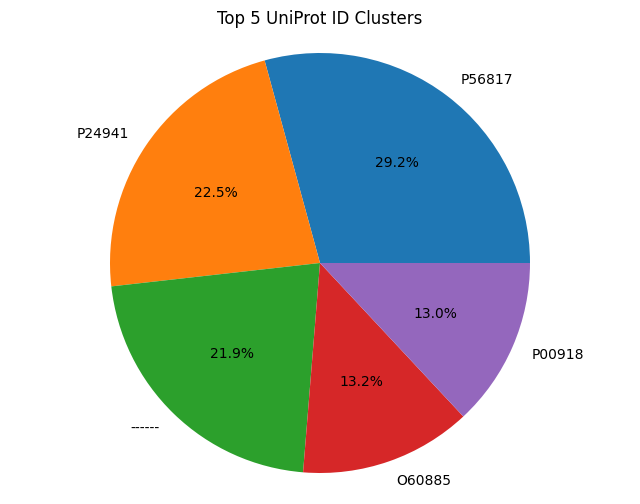

Top 5 UniProt ID Clusters:
P56817: 296
P24941: 228
------: 222
O60885: 134
P00918: 132


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'df' with a column 'uniprot_id'
uniprot_counts = df['uniprot_id'].value_counts()

# Filter for the top N clusters (e.g., top 5)
top_n = 5
top_clusters = uniprot_counts.nlargest(top_n)

# Create a pie chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(top_clusters.values, labels=top_clusters.index, autopct='%1.1f%%')
ax.axis('equal')  # Ensure the pie chart is circular
ax.set_title(f'Top {top_n} UniProt ID Clusters')
plt.show()

# Print information about the top clusters
print(f"Top {top_n} UniProt ID Clusters:")
for cluster, count in top_clusters.items():
    print(f"{cluster}: {count}")

In [ ]:
df

pdb_code  release_year uniprot_id  \
5700      6pht          2019     ------   
3906      5xv7          2018     ------   
322       5hv1          2016     ------   
11055     3ggw          2009     ------   
321       6nzg          2019     ------   
...        ...           ...        ...   
10512     6ex0          2018     W8U368   
12766     5wew          2018     W8UNW6   
3523      6h9x          2019     W9BNU9   
3864      4urn          2014     X5EN43   
3865      4url          2014     X5EN43   

                                protein_name  \
5700          ACETYLPOLYAMINE AMIDOHYDROLASE   
3906   SERINE-ARGININE (SR) PROTEIN KINASE 1   
322             PHOSPHOENOLPYRUVATE SYNTHASE   
11055         ANTIBODY FAB F22-4 LIGHT CHAIN   
321                       BETA-GALACTOSIDASE   
...                                      ...   
10512                  GTP PYROPHOSPHOKINASE   
12766          FOSFOMYCIN RESISTANCE PROTEIN   
3523                     SERINE--TRNA LIGASE   
3864         DNA TOPOISOMERASE IV, B SUBUNIT   
3865         DNA TOPOISOMERASE IV, B SUBUNIT   

                                                  smiles  
5700   [H][O+]([H])B([O+]([H])[H])C([H])([H])C([H])([...  
3906   [H]c1c2c(c([H])c(N3C([H])([H])C([H])([H])C([H]...  
322    [H]OC1=C2N([H])C(=O)/C(C([H])([H])[H])=C([H])\...  
11055  [H]Oc1c([H])c([H])c(C([H])([H])[C@@]([H])(C(=O...  
321    [H]O[C@@]1([H])[C@]([H])(O[H])[C@@]([H])(O[H])...  
...                                                  ...  
10512  [H]OC1([H])c2nc([H])n([C@]3([H])O[C@]([H])(C([...  
12766  [H]c1nc2c(Br)c(=O)n([H])n2c([H])c1-c1nn([H])c(...  
3523   [H]OC([H])([H])[C@@]([H])(C(=O)N([H])S(=O)(=O)...  
3864   [H]Oc1c([H])c([H])c(C(=O)N([H])c2c(O[H])c3c([H...  
3865   [H]O/C(=C1/C(=O)N([C@]2([H])O[C@@]([H])(C([H])...  

[14086 rows x 5 columns]

#**5. Получение скаффолда МУРКО и удаление пустых скаффолдов МУРКО**

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
df_struct = pd.read_excel('GeneralV1.xlsx')
def get_murcko_scaffold(smiles):
    try:
        mol = Chem.MolFromSmiles(str(smiles))
        if mol:
            return Chem.MolToSmiles(MurckoScaffold.GetScaffoldForMol(mol))
        else:
            return ''
    except:
        return ''

# Assuming you have a DataFrame 'df' with a column 'SMILES'
df_struct['murko_scaffold'] = df_struct['smiles'].apply(get_murcko_scaffold)

Выходные данные были обрезаны до нескольких последних строк (5000).
[14:37:15] SMILES Parse Error: syntax error while parsing: nan
[14:37:15] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[14:37:15] SMILES Parse Error: syntax error while parsing: nan
[14:37:15] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[14:37:15] SMILES Parse Error: syntax error while parsing: nan
[14:37:15] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[14:37:15] SMILES Parse Error: syntax error while parsing: nan
[14:37:15] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[14:37:15] SMILES Parse Error: syntax error while parsing: nan
[14:37:15] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[14:37:15] SMILES Parse Error: syntax error while parsing: nan
[14:37:15] SMILES Parse Error: Failed parsing SMILES 'nan' for input: 'nan'
[14:37:15] SMILES Parse Error: syntax error while parsing: nan
[14:37:15] SMILES Parse Error: Fail

In [ ]:
# Assuming you have a DataFrame 'df' with a column 'murko_scaffold'
empty_scaffolds = df['murko_scaffold'].isin([''])
num_empty_scaffolds = empty_scaffolds.sum()

print(f"Number of empty Murcko scaffolds: {num_empty_scaffolds}")

KeyError: 'murko_scaffold'

In [ ]:
df[df['murko_scaffold'].isin([''])].to_excel('noncyclic_failed_general.xlsx')

In [ ]:
# Assuming you have a DataFrame 'df' with a column 'murko_scaffold'
df_struct = df_struct[~df_struct['murko_scaffold'].isin([''])]

In [ ]:
df1 = df.copy()
df = df_struct.copy()

#**Бесполезный код, пропускаем**

Визуализация n-ного лиганда

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Draw
i = int(input('Number of Ligand '))+1
# Function to draw and save the illustration
def draw_illustration(smiles, murko_scaffold, filename):
    mol = Chem.MolFromSmiles(smiles)
    scaffold_mol = Chem.MolFromSmiles(murko_scaffold)

    img = Draw.MolToImage(mol, size=(300, 200), legend=f'Original SMILES: {smiles}')
    img.save('1'+filename)
    img = Draw.MolToImage(scaffold_mol, size=(300, 200), legend=f'Murcko Scaffold: {murko_scaffold}', highlightAtoms=[])

    img.save(filename)

# Example usage
smiles = df['smiles'][i]
murko_scaffold = df.loc[df['smiles'] == smiles, 'murko_scaffold'].values[0]
draw_illustration(smiles, murko_scaffold, 'illustration.png')

Number of Ligand 7


In [ ]:
df.to_csv('wmurcko.csv',sep=';', index=False)

In [ ]:
merged_df

pdb_code  release_year uniprot_id  \
101      5htl          2016     ------   
55       6ndl          2019     ------   
41       6qe0          2019     ------   
63       5g61          2017     ------   
52       6dyw          2019     ------   
...       ...           ...        ...   
5311     5nzn          2018     W5R8B8   
5312     5nze          2018     W5R8B8   
5313     5nzf          2018     W5R8B8   
5314     4qrh          2015     W6E076   
5315     6hly          2018     W8FRA6   

                                           protein_name  \
101                        MSHA BIOGENESIS PROTEIN MSHE   
55                                BIOTIN PROTEIN LIGASE   
41      RIBOSOMAL RNA LARGE SUBUNIT METHYLTRANSFERASE J   
63           ABC TRANSPORTER, SUBSTRATE-BINDING PROTEIN   
52    5'-METHYLTHIOADENOSINE/S-ADENOSYLHOMOCYSTEINE ...   
...                                                 ...   
5311                                      NEURAMINIDASE   
5312                                      NEURAMINIDASE   
5313                                      NEURAMINIDASE   
5314                                   GUANYLATE KINASE   
5315                                  AGROPINE PERMEASE   

                                                 smiles  \
101   [H]O[C@]1([H])[C@]2([H])O[P@@](=O)([O-])OC([H]...   
55    [H]c1nc(N([H])[H])c2nc([H])n(C([H])([H])C([H])...   
41    [H]OC([H])([H])[C@@]1([H])O[C@@]([H])(n2c([H])...   
63    [H]OC([H])([H])[C@@]1(OC([H])([H])[C@@]2(OC([H...   
52    [H]O[C@@]1([H])C([H])([H])[N@+]([H])(C([H])([H...   
...                                                 ...   
5311  [H]C1=C(C(=O)[O-])C([H])([H])[C@]([H])([N+]([H...   
5312  [H]C1=C(C(=O)[O-])C([H])([H])[C@]([H])([N+]([H...   
5313  [H]C1=C(C(=O)[O-])C([H])([H])[C@]([H])([N+]([H...   
5314  [H]O[C@]1([H])[C@]([H])(O[P@@](=O)([O-])O[P+](...   
5315  [H]OC([H])([H])[C@@]([H])(O[H])[C@@]([H])(O[H]...   

                                         murko_scaffold  num_atoms  
101   O=c1[nH]cnc2c1ncn2[C@H]1C[C@@H]2O[PH](=O)OC[C@...         40  
55    O=C1N[C@H]2[C@H](CS[C@H]2CCCCNC(=O)NS(=O)(=O)N...         34  
41    c1ncc2ncn([C@H]3CC[C@@H](C[NH2+]CCNc4ncnc5c4nc...         33  
63    C1CC[C@@H](O[C@@]2(CO[C@@]3(CO[C@@]4(COC5CCCO5...         33  
52    c1ccc(Cn2cc(CCCSC[C@@H]3CC[N@H+](Cc4c[nH]c5cnc...         32  
...                                                 ...        ...  
5311                                          C1=CCCCC1          6  
5312                                          C1=CCCCC1          6  
5313                                          C1=CCCCC1          6  
5314        [NH2+]=c1[nH]c(=O)c2ncn([C@H]3CCCO3)c2[nH]1         16  
5315                                          O=C1CCCN1          6  

[5316 rows x 7 columns]

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

# Assuming you have a DataFrame 'df' with columns 'uniprot_id' and 'SMILES'
df['uniprot_id'] = df['uniprot_id'].astype(str)  # Convert 'uniprot_id' to string
df['murko_scaffold'] = df['smiles'].apply(lambda x: Chem.MolToSmiles(MurckoScaffold.GetScaffoldForMol(Chem.MolFromSmiles(str(x)))) if isinstance(x, str) else '')

# Group by UniProt ID and compute the number of atoms in each Murcko scaffold
grouped = df.groupby('uniprot_id', group_keys=False)['murko_scaffold'].apply(lambda x: x.apply(lambda y: Chem.MolFromSmiles(str(y)).GetNumAtoms() if isinstance(y, str) else 0))

# Merge the grouped data with the original DataFrame
merged_df = df.join(grouped.rename('num_atoms'))

# Sort by 'uniprot_id' and then by the number of atoms in the Murcko scaffold in descending order
merged_df = merged_df.sort_values(['uniprot_id', 'num_atoms'], ascending=[True, False])

print(merged_df)

     pdb_code  release_year uniprot_id  \
101      5htl          2016     ------   
55       6ndl          2019     ------   
41       6qe0          2019     ------   
63       5g61          2017     ------   
52       6dyw          2019     ------   
...       ...           ...        ...   
5311     5nzn          2018     W5R8B8   
5312     5nze          2018     W5R8B8   
5313     5nzf          2018     W5R8B8   
5314     4qrh          2015     W6E076   
5315     6hly          2018     W8FRA6   

                                           protein_name  \
101                        MSHA BIOGENESIS PROTEIN MSHE   
55                                BIOTIN PROTEIN LIGASE   
41      RIBOSOMAL RNA LARGE SUBUNIT METHYLTRANSFERASE J   
63           ABC TRANSPORTER, SUBSTRATE-BINDING PROTEIN   
52    5'-METHYLTHIOADENOSINE/S-ADENOSYLHOMOCYSTEINE ...   
...                                                 ...   
5311                                      NEURAMINIDASE   
5312                   

In [ ]:
merged_df.to_csv('murcko_with_length.csv',sep=';')

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdFMCS

# Функция для проверки, является ли скаффолд подструктурой других скаффолдов
def is_substructure(scaffold, scaffolds):
    mol = Chem.MolFromSmiles(scaffold)
    for other_scaffold in scaffolds:
        other_mol = Chem.MolFromSmiles(other_scaffold)
        if mol.HasSubstructMatch(other_mol):
            return True
    return False

# Группируем скаффолды по UniProt ID
grouped = merged_df.groupby('uniprot_id')['murko_scaffold'].apply(list)

# Создаем словарь для хранения результатов проверки
substructure_check = {}

# Проверяем каждый UniProt ID
for uniprot_id, scaffolds in grouped.items():
    substructure_check[uniprot_id] = {}
    for scaffold in scaffolds:
        others = [s for s in scaffolds if s != scaffold]
        substructure_check[uniprot_id][scaffold] = is_substructure(scaffold, others)

KeyError: 'Column not found: murko_scaffold'

In [ ]:
from collections import defaultdict

# Создаем словарь для хранения кластеров
clusters = defaultdict(list)

# Проходим по результатам проверки
for uniprot_id, scaffolds in substructure_check.items():
    for scaffold, is_substructure in scaffolds.items():
        if is_substructure:
            # Если скаффолд является подструктурой, добавляем его в кластер
            clusters[scaffold].append(uniprot_id)

In [ ]:
for scaffold, uniprot_ids in clusters.items():
    print(f"Scaffold: {scaffold}")
    print(f"UniProt IDs: {', '.join(uniprot_ids)}")
    print()

Scaffold: O=c1[nH]cnc2c1ncn2[C@H]1C[C@@H]2O[PH](=O)OC[C@H]3O[C@@H](n4cnc5c(=O)[nH]cnc54)C[C@@H]3O[PH](=O)OC[C@H]2O1
UniProt IDs: ------

Scaffold: O=C1N[C@H]2[C@H](CS[C@H]2CCCCNC(=O)NS(=O)(=O)NCCCCn2cnc3cncnc32)N1
UniProt IDs: ------

Scaffold: c1ncc2ncn([C@H]3CC[C@@H](C[NH2+]CCNc4ncnc5c4ncn5[C@H]4CCCO4)O3)c2n1
UniProt IDs: ------

Scaffold: C1CC[C@@H](O[C@@]2(CO[C@@]3(CO[C@@]4(COC5CCCO5)CCCO4)CCCO3)CCCO2)OC1
UniProt IDs: ------

Scaffold: c1ccc(Cn2cc(CCCSC[C@@H]3CC[N@H+](Cc4c[nH]c5cncnc45)C3)nn2)cc1
UniProt IDs: ------, Q13126

Scaffold: O=C1C=C([C@H]2CCC3C2CC[C@@H]2C4CC[C@H](O[C@H]5CCCCO5)C[C@H]4CC[C@@H]32)CO1
UniProt IDs: ------

Scaffold: O=C(NC[C@@H]1CCCO1)c1cc(Cc2ccco2)c2nc3ccccn3c(=O)c2c1
UniProt IDs: ------

Scaffold: C1CC[C@@H](OC[C@@H]2CCC[C@@H](OC[C@@H]3CCC[C@@H](OC4CCCO4)O3)O2)OC1
UniProt IDs: ------

Scaffold: O=C1c2ccccc2C(=O)c2c1ccc1c2N[C@H]2C#C/C=C\C#CC[C@@]13OC23
UniProt IDs: ------

Scaffold: O=C1c2ccccc2C(=O)c2c1ccc1c2N[C@H]2/C=C\C=C/C=C\C[C@@]13OC23
UniProt IDs: ---

#**6. Визуализация**

Введите количество выводимых наибольших кластеров (или нажмите Enter для вывода всех): 10


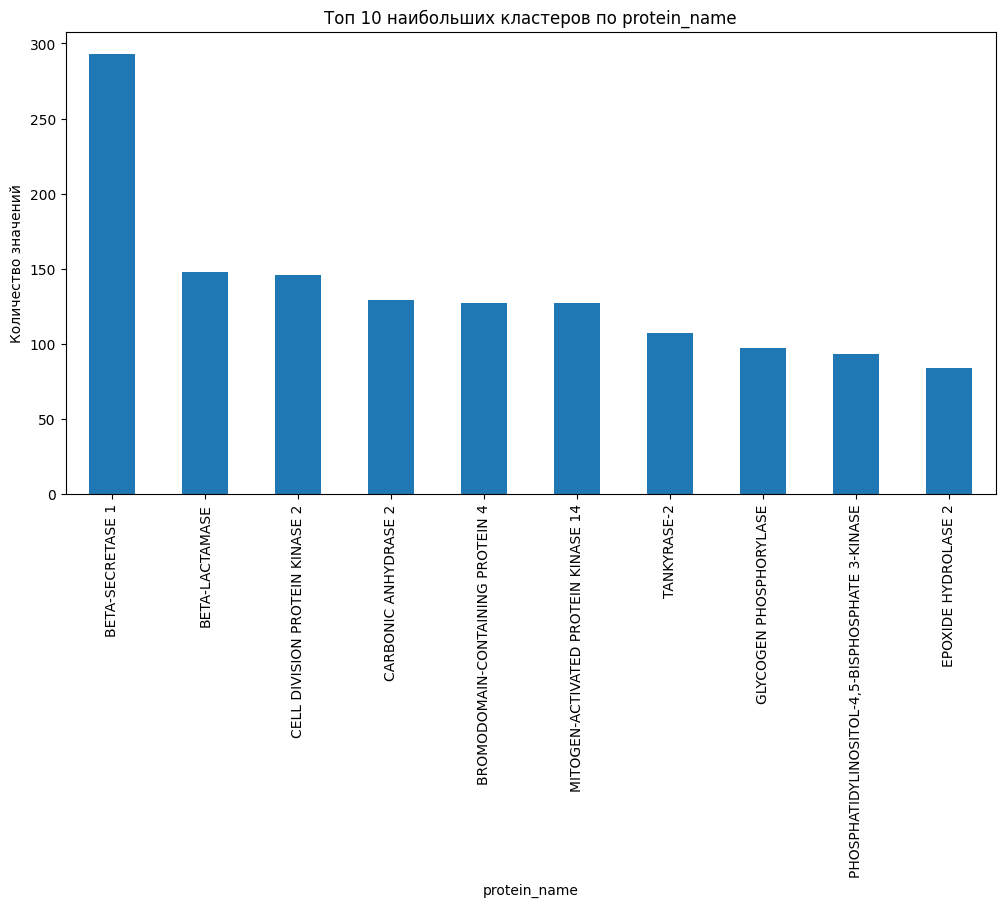

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Чтение данных из файла CSV
data = df.copy()#pd.read_csv('wmurcko.csv',sep=';')

# Группировка по protein_name и подсчет количества значений в каждой группе
cluster_counts = data['protein_name'].value_counts()

# Запрос ввода количества выводимых наибольших кластеров
n = input("Введите количество выводимых наибольших кластеров (или нажмите Enter для вывода всех): ")

# Если ввод пустой, выводим все кластеры
if n == "":
    cluster_counts.plot.bar(figsize=(12, 6), rot=90)
    plt.title("Распределение количества значений по protein_name")
    plt.xlabel("protein_name")
    plt.ylabel("Количество значений")
    plt.show()
else:
    # Иначе, выводим заданное количество наибольших кластеров
    n = int(n)
    top_clusters = cluster_counts.nlargest(n)
    top_clusters.plot.bar(figsize=(12, 6), rot=90)
    plt.title(f"Топ {n} наибольших кластеров по protein_name")
    plt.xlabel("protein_name")
    plt.ylabel("Количество значений")
    plt.show()

Введите количество выводимых наибольших кластеров (или нажмите Enter для вывода всех): 10


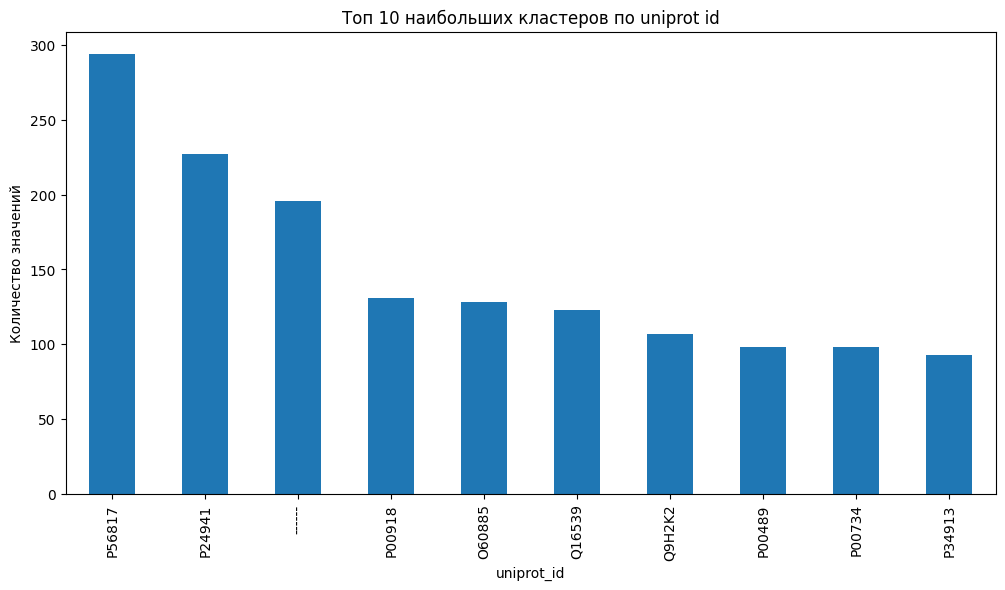

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Чтение данных из файла CSV
#data = pd.read_csv('wmurcko.csv',sep=';')

# Группировка по protein_name и подсчет количества значений в каждой группе
cluster_counts = data['uniprot_id'].value_counts()

# Запрос ввода количества выводимых наибольших кластеров
n = input("Введите количество выводимых наибольших кластеров (или нажмите Enter для вывода всех): ")

# Если ввод пустой, выводим все кластеры
if n == "":
    cluster_counts.plot.bar(figsize=(12, 6), rot=90)
    plt.title("Распределение количества значений по uniprot id")
    plt.xlabel("uniprot_id")
    plt.ylabel("Количество значений")
    plt.show()
else:
    # Иначе, выводим заданное количество наибольших кластеров
    n = int(n)
    top_clusters = cluster_counts.nlargest(n)
    top_clusters.plot.bar(figsize=(12, 6), rot=90)
    plt.title(f"Топ {n} наибольших кластеров по uniprot id")
    plt.xlabel("uniprot_id")
    plt.ylabel("Количество значений")
    plt.show()

#**Еще немного бесполезного кода**

**Проверка на одинаковый uniprot_id или имя** (суть была в проверке того, по чему потом сортировать - вывод - по id)

In [ ]:
import pandas as pd

# Чтение данных из файла CSV
data = pd.read_csv('wmurcko.csv',sep=';')

# Группировка по protein_name и uniprot_id
grouped = data.groupby(['protein_name', 'uniprot_id'])

# Поиск белков с одинаковым protein_name, но разными uniprot_id
same_name_diff_uniprot = grouped.filter(lambda x: len(x) > 1)
same_name_diff_uniprot = same_name_diff_uniprot.reset_index()

# Поиск белков с одинаковым uniprot_id, но разными protein_name
same_uniprot_diff_name = grouped.filter(lambda x: len(x['protein_name'].unique()) > 1)
same_uniprot_diff_name = same_uniprot_diff_name.reset_index()

# Создание списков для хранения пар
pairs_same_name = []
pairs_same_uniprot = []

# Формирование пар белков с одинаковым protein_name, но разными uniprot_id
for name, group in same_name_diff_uniprot.groupby('protein_name'):
    uniprot_ids = group['uniprot_id'].tolist()
    for i in range(len(uniprot_ids)):
        for j in range(i + 1, len(uniprot_ids)):
            pair = (f"{name} - {uniprot_ids[i]}", f"{name} - {uniprot_ids[j]}")
            pairs_same_name.append(pair)

# Формирование пар белков с одинаковым uniprot_id, но разными protein_name
for uniprot, group in same_uniprot_diff_name.groupby('uniprot_id'):
    names = group['protein_name'].tolist()
    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            pair = (f"{names[i]} - {uniprot}", f"{names[j]} - {uniprot}")
            pairs_same_uniprot.append(pair)

# Вывод результатов без повторений
print("Белки с одинаковым protein_name, но разными uniprot_id:")
for pair in set(pairs_same_name):
    print(pair)
print()

print("Белки с одинаковым uniprot_id, но разными protein_name:")
for pair in set(pairs_same_uniprot):
    print(pair)

Белки с одинаковым protein_name, но разными uniprot_id:
('GLUCOSE-1-PHOSPHATE THYMIDYLYLTRANSFERASE - G3XCK4', 'GLUCOSE-1-PHOSPHATE THYMIDYLYLTRANSFERASE - G3XCK4')
('COAGULATION FACTOR VIIA - P08709', 'COAGULATION FACTOR VIIA - P08709')
('HIV-1 PROTEASE - P03368', 'HIV-1 PROTEASE - Q90EB9')
('BROMODOMAIN ADJACENT TO ZINC FINGER DOMAIN PROTEIN 2A - Q9UIF9', 'BROMODOMAIN ADJACENT TO ZINC FINGER DOMAIN PROTEIN 2A - Q9UIF9')
('HISTONE DEACETYLASE 8 - Q9BY41', 'HISTONE DEACETYLASE 8 - Q9BY41')
('HIV-1 PROTEASE - P04587', 'HIV-1 PROTEASE - Q9QB59')
('IMPORTIN SUBUNIT ALPHA-1 - P52293', 'IMPORTIN SUBUNIT ALPHA-1 - P52293')
('HIV-1 PROTEASE - Q9QB59', 'HIV-1 PROTEASE - V5Y949')
('FERRITIN LIGHT CHAIN - P02791', 'FERRITIN LIGHT CHAIN - P02791')
('GLYCOGEN SYNTHASE KINASE-3 BETA - P49841', 'GLYCOGEN SYNTHASE KINASE-3 BETA - P49841')
('HIV-1 PROTEASE - P03366', 'HIV-1 PROTEASE - Q90K99')
('HIV-1 PROTEASE - O38716', 'HIV-1 PROTEASE - Q8ULI3')
('PUTATIVE FRUCTOSE-1,6-BISPHOSPHATE ALDOLASE - O97447

**Проверка на пробелы и табуляции в начале**

In [ ]:
import pandas as pd
from itertools import combinations

# Чтение данных из файла CSV
data = pd.read_csv('wmurcko.csv',sep=';')

# Получение списка уникальных имен белков
protein_names = data['protein_name'].unique().tolist()

# Функция для удаления лидирующих/заключительных пробелов и табуляций
def strip_whitespace(name):
    return name.strip(' \t')

# Создание списка пар имен белков, различающихся только по лидирующим/заключительным пробелам или табуляциям
pairs = []
for pair in combinations(protein_names, 2):
    stripped_pair = [strip_whitespace(name) for name in pair]
    if len(set(stripped_pair)) == 1:
        pairs.append(pair)

# Вывод результатов
print("Пары имен белков, которые отличаются только по переднему и/или заднему пробелу или табуляции:")
for pair in pairs:
    print(pair)

Пары имен белков, которые отличаются только по переднему и/или заднему пробелу или табуляции:


In [ ]:
import pandas as pd

# Чтение данных из файла CSV
#data = pd.read_csv('wmurcko.csv',sep=';')

# Подсчет количества уникальных значений uniprot_id
unique_uniprot_count = data['uniprot_id'].nunique()
print(f"Количество уникальных значений uniprot_id: {unique_uniprot_count}")

# Подсчет количества значений uniprot_id, встречающихся более одного раза
uniprot_value_counts = data['uniprot_id'].value_counts()
multiple_entries_count = sum(uniprot_value_counts > 1)
print(f"Количество значений uniprot_id с более чем одним вхождением: {multiple_entries_count}")

Количество уникальных значений uniprot_id: 2883
Количество значений uniprot_id с более чем одним вхождением: 1442


**Добавляем размеры скаффолда Мурко**

In [ ]:
import pandas as pd

# Читаем данные из CSV-файла
data = pd.read_csv('wmurcko.csv', sep=';')

from rdkit import Chem

# Функция для подсчета количества атомов в скаффолде MURKO
def count_murko_atoms(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return len(mol.GetAtoms())
    except:
        pass
    return 0

# Создаем новую колонку для количества атомов в скаффолдах MURKO
data['murko_scaffold_atoms'] = data['murko_scaffold'].apply(count_murko_atoms)

In [ ]:
data

pdb_code  release_year uniprot_id  \
0        6eiz          2018     ------   
1        6d9s          2019     ------   
2        5ldm          2017     ------   
3        5ldp          2017     ------   
4        6mqe          2019     ------   
...       ...           ...        ...   
5311     5nzn          2018     W5R8B8   
5312     5nze          2018     W5R8B8   
5313     5nzf          2018     W5R8B8   
5314     4qrh          2015     W6E076   
5315     6hly          2018     W8FRA6   

                                protein_name  \
0                                    CC-HEX2   
1     HYPOXANTHINE PHOSPHORIBOSYLTRANSFERASE   
2         RNA 2',3'-CYCLIC PHOSPHODIESTERASE   
3         RNA 2',3'-CYCLIC PHOSPHODIESTERASE   
4          DFPHA.15 ANTIBODY FAB LIGHT CHAIN   
...                                      ...   
5311                           NEURAMINIDASE   
5312                           NEURAMINIDASE   
5313                           NEURAMINIDASE   
5314                        GUANYLATE KINASE   
5315                       AGROPINE PERMEASE   

                                                 smiles  \
0     [H]OC([H])([H])/C([H])=C(\C([H])([H])[H])C([H]...   
1     [H]O[C@]1([H])[C@]([H])(O[P@@](=O)([O-])O[P+](...   
2     [H]OC([H])([H])[C@@]1([H])O[C@@]([H])(n2c([H])...   
3     [H]O[C@@]1([H])[C@@]([H])(O[H])[C@]([H])(n2c([...   
4     [H]c1c([H])c([H])c(C([H])([H])[C@@]([H])(C(=O)...   
...                                                 ...   
5311  [H]C1=C(C(=O)[O-])C([H])([H])[C@]([H])([N+]([H...   
5312  [H]C1=C(C(=O)[O-])C([H])([H])[C@]([H])([N+]([H...   
5313  [H]C1=C(C(=O)[O-])C([H])([H])[C@]([H])([N+]([H...   
5314  [H]O[C@]1([H])[C@]([H])(O[P@@](=O)([O-])O[P+](...   
5315  [H]OC([H])([H])[C@@]([H])(O[H])[C@@]([H])(O[H]...   

                                   murko_scaffold  murko_scaffold_atoms  
0                                             NaN                     0  
1     [NH2+]=c1[nH]c(=O)c2ncn([C@H]3CCCO3)c2[nH]1                    16  
2                      c1ncc2ncn([C@H]3CCCO3)c2n1                    14  
3                      c1ncc2ncn([C@H]3CCCO3)c2n1                    14  
4                                        c1ccccc1                     6  
...                                           ...                   ...  
5311                                    C1=CCCCC1                     6  
5312                                    C1=CCCCC1                     6  
5313                                    C1=CCCCC1                     6  
5314  [NH2+]=c1[nH]c(=O)c2ncn([C@H]3CCCO3)c2[nH]1                    16  
5315                                    O=C1CCCN1                     6  

[5316 rows x 7 columns]

In [ ]:
data

pdb_code  release_year uniprot_id  \
0        6eiz          2018     ------   
1        6d9s          2019     ------   
2        5ldm          2017     ------   
3        5ldp          2017     ------   
4        6mqe          2019     ------   
...       ...           ...        ...   
5311     5nzn          2018     W5R8B8   
5312     5nze          2018     W5R8B8   
5313     5nzf          2018     W5R8B8   
5314     4qrh          2015     W6E076   
5315     6hly          2018     W8FRA6   

                                protein_name  \
0                                    CC-HEX2   
1     HYPOXANTHINE PHOSPHORIBOSYLTRANSFERASE   
2         RNA 2',3'-CYCLIC PHOSPHODIESTERASE   
3         RNA 2',3'-CYCLIC PHOSPHODIESTERASE   
4          DFPHA.15 ANTIBODY FAB LIGHT CHAIN   
...                                      ...   
5311                           NEURAMINIDASE   
5312                           NEURAMINIDASE   
5313                           NEURAMINIDASE   
5314                        GUANYLATE KINASE   
5315                       AGROPINE PERMEASE   

                                                 smiles  \
0     [H]OC([H])([H])/C([H])=C(\C([H])([H])[H])C([H]...   
1     [H]O[C@]1([H])[C@]([H])(O[P@@](=O)([O-])O[P+](...   
2     [H]OC([H])([H])[C@@]1([H])O[C@@]([H])(n2c([H])...   
3     [H]O[C@@]1([H])[C@@]([H])(O[H])[C@]([H])(n2c([...   
4     [H]c1c([H])c([H])c(C([H])([H])[C@@]([H])(C(=O)...   
...                                                 ...   
5311  [H]C1=C(C(=O)[O-])C([H])([H])[C@]([H])([N+]([H...   
5312  [H]C1=C(C(=O)[O-])C([H])([H])[C@]([H])([N+]([H...   
5313  [H]C1=C(C(=O)[O-])C([H])([H])[C@]([H])([N+]([H...   
5314  [H]O[C@]1([H])[C@]([H])(O[P@@](=O)([O-])O[P+](...   
5315  [H]OC([H])([H])[C@@]([H])(O[H])[C@@]([H])(O[H]...   

                                   murko_scaffold  murko_scaffold_atoms  
0                                             NaN                     0  
1     [NH2+]=c1[nH]c(=O)c2ncn([C@H]3CCCO3)c2[nH]1                    16  
2                      c1ncc2ncn([C@H]3CCCO3)c2n1                    14  
3                      c1ncc2ncn([C@H]3CCCO3)c2n1                    14  
4                                        c1ccccc1                     6  
...                                           ...                   ...  
5311                                    C1=CCCCC1                     6  
5312                                    C1=CCCCC1                     6  
5313                                    C1=CCCCC1                     6  
5314  [NH2+]=c1[nH]c(=O)c2ncn([C@H]3CCCO3)c2[nH]1                    16  
5315                                    O=C1CCCN1                     6  

[5316 rows x 7 columns]

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdFMCS

# Загрузка данных из CSV файла
data = pd.read_csv('cyclic.csv',sep=';')

# Функция для проверки наличия подструктуры
def has_substructure(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    return mol2.HasSubstructMatch(mol1)

# Словарь для хранения кластеров
clusters = {}

# Итерация по строкам данных
for idx, row in data.iterrows():
    murko_scaffold = row['murko_scaffold']
    smiles = row['smiles']

    # Проверка наличия подструктуры для каждого соединения
    has_substructure_list = [has_substructure(murko_scaffold, s) for s in data['smiles']]

    # Формирование кластера на основе наличия общих подструктур
    cluster_key = tuple(has_substructure_list)
    if cluster_key in clusters:
        clusters[cluster_key].append(row)
    else:
        clusters[cluster_key] = [row]

# Вывод результатов
for cluster_key, cluster_data in clusters.items():
    print(f"Cluster with substructure pattern: {cluster_key}")
    print(cluster_data)
    print()

Выходные данные были обрезаны до нескольких последних строк (5000).
release_year                                     2013
uniprot_id                                     P00720
protein_name                                 LYSOZYME
smiles            [H]Oc1c([H])c([H])c([H])c([H])c1[H]
murko_scaffold                               c1ccccc1
Name: 867, dtype: object, pdb_code                                                       3fvl
release_year                                                   2010
uniprot_id                                                   P00730
protein_name                                    CARBOXYPEPTIDASE A1
smiles            [H]OC([H])([H])C(=O)C([H])([H])[C@]([H])(C(=O)...
murko_scaffold                                             c1ccccc1
Name: 880, dtype: object, pdb_code                                                       3fx6
release_year                                                   2009
uniprot_id                                                   P0073

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[pdb_code                                                       3c4h
release_year                                                   2008
uniprot_id                                                   Q9Y6F1
protein_name                         POLY [ADP-RIBOSE] POLYMERASE 3
smiles            [H]n1c(C([H])([H])[H])nc2c(c1=O)C([H])([H])SC(...
murko_scaffold                                  O=c1[nH]cnc2c1CSCC2
Name: 4793, dtype: object]

Cluster with substructure pattern: (False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, Fa

In [ ]:
results = []

# Формирование результатов в виде списка словарей
for cluster_key, cluster_data in clusters.items():
    target_name, uniprot_id = cluster_data['target'][0], cluster_data['target'][1]
    for smiles, scaffold in cluster_data['compounds']:
        results.append({
            'protein_name': target_name,
            'uniprot_id': uniprot_id,
            'smiles': smiles,
            'murko_scaffold': scaffold
        })

# Создание DataFrame и сохранение в CSV файл
results_df = pd.DataFrame(results)
results_df.to_csv('results.csv',sep=';', index=False)

TypeError: list indices must be integers or slices, not str

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold


# Вычислить количество атомов в каждом скаффолде Murcko
data['murko_scaffold_size'] = data['murko_scaffold'].apply(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())

# Группировать по uniprot_id и найти минимальное количество атомов в скаффолде
min_scaffold_sizes = data.groupby('uniprot_id')['murko_scaffold_size'].min().reset_index()

# Объединить минимальные размеры скаффолдов с исходными данными
data = data.merge(min_scaffold_sizes, on='uniprot_id', how='left', suffixes=('', '_min'))

# Создать функцию для поиска подструктур
def find_substructure(scaffold, uniprot_id, data):
    scaffold_mol = Chem.MolFromSmiles(scaffold)
    matches = data.loc[data['uniprot_id'] == uniprot_id, 'murko_scaffold'].apply(lambda x: scaffold_mol.HasSubstructMatch(Chem.MolFromSmiles(x)))
    return matches.any()

# Применить функцию поиска подструктур к каждому uniprot_id и скаффолду
data['has_min_substructure'] = data.apply(lambda x: find_substructure(x['murko_scaffold'], x['uniprot_id'], data) if x['murko_scaffold_size'] == x['murko_scaffold_size_min'] else False, axis=1)

# Отфильтровать строки, содержащие минимальную подструктуру
data = data[data['has_min_substructure']]

# Отсортировать по uniprot_id, murko_scaffold и murko_scaffold_size
data = data.sort_values(['uniprot_id', 'murko_scaffold', 'murko_scaffold_size'])

# Вывести результат
print(data[['uniprot_id', 'murko_scaffold', 'murko_scaffold_size']])

     uniprot_id                               murko_scaffold  \
55       ------                                 C1CC[NH2+]C1   
62       ------                                 C1CC[NH2+]C1   
4        ------                                   c1c[nH]cn1   
63       ------                                   c1c[nH]cn1   
64       ------                                   c1c[nH]cn1   
...         ...                                          ...   
4834     W5R8B8                                    C1=CCCCC1   
4835     W5R8B8                                    C1=CCCCC1   
4836     W5R8B8                                    C1=CCCCC1   
4837     W6E076  [NH2+]=c1[nH]c(=O)c2ncn([C@H]3CCCO3)c2[nH]1   
4838     W8FRA6                                    O=C1CCCN1   

      murko_scaffold_size  
55                      5  
62                      5  
4                       5  
63                      5  
64                      5  
...                   ...  
4834                    6  
4835   

In [ ]:
import pandas as pd
from rdkit import Chem

# Читаем файл cyclic.csv, разделенный точкой с запятой
df = pd.read_csv('cyclic.csv', sep=';')

# Функция для подсчета количества атомов в SMILES
def count_atoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return mol.GetNumAtoms()
    else:
        return 0

# Применяем функцию count_atoms к колонке murko_scaffold и создаем новую колонку murko_scaffold_size
df['murko_scaffold_size'] = df['murko_scaffold'].apply(count_atoms)

# Выводим первые 5 строк результирующего DataFrame
print(df.head())

  pdb_code  release_year uniprot_id  \
0     6d9s          2019     ------   
1     5ldm          2017     ------   
2     5ldp          2017     ------   
3     6mqe          2019     ------   
4     5yhg          2018     ------   

                                       protein_name  \
0            HYPOXANTHINE PHOSPHORIBOSYLTRANSFERASE   
1                RNA 2',3'-CYCLIC PHOSPHODIESTERASE   
2                RNA 2',3'-CYCLIC PHOSPHODIESTERASE   
3                 DFPHA.15 ANTIBODY FAB LIGHT CHAIN   
4  NICKEL ABC TRANSPORTER SUBSTRATE-BINDING PROTEIN   

                                              smiles  \
0  [H]O[C@]1([H])[C@]([H])(O[P@@](=O)([O-])O[P+](...   
1  [H]OC([H])([H])[C@@]1([H])O[C@@]([H])(n2c([H])...   
2  [H]O[C@@]1([H])[C@@]([H])(O[H])[C@]([H])(n2c([...   
3  [H]c1c([H])c([H])c(C([H])([H])[C@@]([H])(C(=O)...   
4  [H]c1nc([H])n([H])c1C([H])([H])[C@]([H])(C(=O)...   

                                murko_scaffold  murko_scaffold_size  
0  [NH2+]=c1[nH]c(=O)c2ncn(

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdFMCS

def find_minimal_scaffolds(df):
    scaffolds = []
    for group_id, group in df.groupby('uniprot_id'):
        smiles_list = group['murko_scaffold'].tolist()
        mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

        min_scaffold = None
        max_matches = 0

        for mol in mols:
            matches = sum(1 for other_mol in mols if mol.HasSubstructMatch(other_mol))
            if matches > max_matches or (matches == max_matches and mol.GetNumAtoms() < min_scaffold.GetNumAtoms()):
                min_scaffold = mol
                max_matches = matches

        if min_scaffold:
            scaffold_smiles = Chem.MolToSmiles(min_scaffold)
            scaffolds.append({'uniprot_id': group_id, 'minimal_scaffold': scaffold_smiles})

    return pd.DataFrame(scaffolds)

# Применение функции к исходному DataFrame
minimal_scaffolds_df = find_minimal_scaffolds(df)
minimal_scaffolds_df

uniprot_id                                   minimal_scaffold
0        ------         O=C(Nc1ccccn1)c1ccc2[nH]c(CNc3ccccc3)nc2c1
1        A0A024                                           c1ccccc1
2        A0A073                            c1ccc(O[C@H]2CCCCO2)cc1
3        A0A078                                         O=C1CCCCO1
4        A0A0H2      C1CC[C@@H](OC[C@@H]2CCC[C@@H](OC3CCCO3)O2)OC1
...         ...                                                ...
1320     V5YAB1  O=C(N[C@H](CCNS(=O)(=O)c1ccccc1)Cc1ccccc1)O[C@...
1321     V9HWF5                                           c1ccncc1
1322     W5R8B8                                          C1=CCCCC1
1323     W6E076        [NH2+]=c1[nH]c(=O)c2ncn([C@H]3CCCO3)c2[nH]1
1324     W8FRA6                                          O=C1CCCN1

[1325 rows x 2 columns]

No charts were generated by quickchart


In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdFMCS

def find_minimal_substructures(df):
    result = []
    for _, row in df.iterrows():
        uniprot_id = row['uniprot_id']
        ligand_scaffold = row['murko_scaffold']
        ligand_mol = Chem.MolFromSmiles(ligand_scaffold)

        min_substructure = ligand_scaffold
        min_substructure_atoms = ligand_mol.GetNumAtoms()
        has_no_relatives = True

        group = df[df['uniprot_id'] == uniprot_id]
        for _, other_row in group.iterrows():
            other_scaffold = other_row['murko_scaffold']
            other_mol = Chem.MolFromSmiles(other_scaffold)

            if ligand_mol != other_mol and other_mol.HasSubstructMatch(ligand_mol):
                other_atoms = other_mol.GetNumAtoms()
                if other_atoms < min_substructure_atoms:
                    min_substructure = other_scaffold
                    min_substructure_atoms = other_atoms
                    has_no_relatives = False

        result.append({
            'uniprot_id': uniprot_id,
            'murko_scaffold': ligand_scaffold,
            'murcko_min_substructure': min_substructure,
            'has_no_relatives': has_no_relatives
        })

    return pd.DataFrame(result)

# Применение функции к исходному DataFrame
minimal_substructures_df = find_minimal_substructures(df)
print(minimal_substructures_df)

     uniprot_id                               murko_scaffold  \
0        ------  [NH2+]=c1[nH]c(=O)c2ncn([C@H]3CCCO3)c2[nH]1   
1        ------                   c1ncc2ncn([C@H]3CCCO3)c2n1   
2        ------                   c1ncc2ncn([C@H]3CCCO3)c2n1   
3        ------                                     c1ccccc1   
4        ------                                   c1c[nH]cn1   
...         ...                                          ...   
4834     W5R8B8                                    C1=CCCCC1   
4835     W5R8B8                                    C1=CCCCC1   
4836     W5R8B8                                    C1=CCCCC1   
4837     W6E076  [NH2+]=c1[nH]c(=O)c2ncn([C@H]3CCCO3)c2[nH]1   
4838     W8FRA6                                    O=C1CCCN1   

                          murcko_min_substructure  has_no_relatives  
0     [NH2+]=c1[nH]c(=O)c2ncn([C@H]3CCCO3)c2[nH]1              True  
1                      c1ncc2ncn([C@H]3CCCO3)c2n1              True  
2                    

In [ ]:
merged_df = pd.merge(df, minimal_substructures_df, on=['uniprot_id', 'murko_scaffold'], how='left')

In [ ]:
# Подсчет количества лигандов без родственных скаффолдов
no_relatives_count = merged_df['has_no_relatives'].sum()

# Подсчет количества лигандов с родственными скаффолдами
has_relatives_count = len(merged_df) - no_relatives_count

print(f"Количество лигандов без родственных скаффолдов: {no_relatives_count}")
print(f"Количество лигандов с родственными скаффолдами: {has_relatives_count}")

Количество лигандов без родственных скаффолдов: 12305
Количество лигандов с родственными скаффолдами: 0


In [ ]:
import pandas as pd

# Читаем CSV-файл в DataFrame
#df = pd.read_csv('cyclic.csv', sep=';')

# Группируем строки по uniprot_id
grouped = df.groupby('uniprot_id')

# Создаем список для хранения групп, удовлетворяющих условию
matching_groups = []

# Проходим по каждой группе
for group_name, group in grouped:
    # Получаем список murko_scaffold для текущей группы
    scaffolds = group['murko_scaffold'].tolist()

    # Проверяем, существует ли murko_scaffold, который является подструктурой для всех остальных
    for scaffold in scaffolds:
        is_substring = True
        for other_scaffold in scaffolds:
            if scaffold not in other_scaffold:
                is_substring = False
                break

        # Если такой murko_scaffold найден, добавляем группу в список
        if is_substring:
            matching_groups.append(group)
            break

# Выводим найденные группы
if matching_groups:
    print("Найдены следующие группы, удовлетворяющие условию:")
    for group in matching_groups:
        print(group)
else:
    print("Групп, удовлетворяющих условию, не найдено.")

Выходные данные были обрезаны до нескольких последних строк (5000).

                                                 smiles  \
3693  [H]O[C@]1(C([H])([H])[H])C([H])([H])[C@@]([H])...   

                                         murko_scaffold  
3693  O=C1CCCCOC(=O)C[C@@H](O[C@H]2CCCCO2)C[C@@H](O[...  
      pdb_code  release_year uniprot_id    protein_name  \
13541     6oos          2019     Q3HWC9  NL4-3 PROTEASE   
13542     6oot          2019     Q3HWC9  NL4-3 PROTEASE   

                                                  smiles  \
13541  [H]O[C@]([H])(C([H])([H])N(C([H])([H])C([H])(C...   
13542  [H]O[C@]([H])(C([H])([H])N(C([H])([H])C([H])(C...   

                                          murko_scaffold  
13541  O=C(N[C@H](CCNS(=O)(=O)c1ccccc1)Cc1ccccc1)O[C@...  
13542  O=C(N[C@H](CCNS(=O)(=O)c1ccccc1)Cc1ccccc1)O[C@...  
     pdb_code  release_year uniprot_id                      protein_name  \
1995     2o7e          2007     Q3IWB0  PUTATIVE HISTIDINE AMMONIA-LYASE   

       

#**7. Группировка по общему скаффолду МУРКО и подсчет атомов в структуре**

In [ ]:
import pandas as pd

# Загрузите данные из файла CSV
#df = pd.read_csv('cyclic.csv', sep=';')

# Создайте новую колонку 'group_number', где каждая группа имеет уникальный номер
df['group_number'] = df.groupby(['uniprot_id', 'murko_scaffold']).ngroup() + 1

# Сохраните обновленный DataFrame обратно в CSV
#df.to_csv('cyclic1.csv', sep=';', index=False)


In [ ]:
df['group_number'].min()

1

In [ ]:
def count_atoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return mol.GetNumAtoms()
    else:
        return None

# Создание нового столбца с количеством атомов
df['num_atoms'] = df['smiles'].apply(count_atoms)



[14:39:20] Unusual charge on atom 14 number of radical electrons set to zero
[14:39:20] Unusual charge on atom 16 number of radical electrons set to zero
[14:39:20] Unusual charge on atom 18 number of radical electrons set to zero
[14:39:20] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[14:39:20] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[14:39:21] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[14:39:21] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[14:39:21] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[14:39:21] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[14:39:21] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[14:39:22] Unusual charge on atom 18 number of radical 

In [ ]:
df.to_excel('cyclic1_with_atoms.csv', sep=';', index=False)

#**8. Чтение энергий**

In [ ]:
import pandas as pd

# Читаем данные, используя регулярное выражение \s+ в качестве разделителя столбцов
data = pd.read_csv('energy.2020', sep=r'\s+', engine='python',)



   2r58  2.00  2007  2.00.1    Kd=10mM  //  2r58.pdf  (MLY)
0  3c2f  2.35  2008     2.0  Kd=10.1mM  //  3c2f.pdf  (PRP)
1  3g2y  1.31  2009     2.0    Ki=10mM  //  3g2y.pdf  (GF4)
2  3pce  2.06  1998     2.0    Ki=10mM  //  3pce.pdf  (3HP)
3  4qsu  1.90  2014     2.0    Kd=10mM  //  4qsu.pdf  (TDR)
4  4qsv  1.90  2014     2.0    Kd=10mM  //  4qsv.pdf  (THM)


In [ ]:
df

pdb_code  release_year uniprot_id  \
3906      5xv7          2018     ------   
322       5hv1          2016     ------   
11055     3ggw          2009     ------   
321       6nzg          2019     ------   
5381      3srg          2012     ------   
...        ...           ...        ...   
10512     6ex0          2018     W8U368   
12766     5wew          2018     W8UNW6   
3523      6h9x          2019     W9BNU9   
3864      4urn          2014     X5EN43   
3865      4url          2014     X5EN43   

                                protein_name  \
3906   SERINE-ARGININE (SR) PROTEIN KINASE 1   
322             PHOSPHOENOLPYRUVATE SYNTHASE   
11055         ANTIBODY FAB F22-4 LIGHT CHAIN   
321                       BETA-GALACTOSIDASE   
5381                       SERUM PARAOXONASE   
...                                      ...   
10512                  GTP PYROPHOSPHOKINASE   
12766          FOSFOMYCIN RESISTANCE PROTEIN   
3523                     SERINE--TRNA LIGASE   
3864         DNA TOPOISOMERASE IV, B SUBUNIT   
3865         DNA TOPOISOMERASE IV, B SUBUNIT   

                                                  smiles  \
3906   [H]c1c2c(c([H])c(N3C([H])([H])C([H])([H])C([H]...   
322    [H]OC1=C2N([H])C(=O)/C(C([H])([H])[H])=C([H])\...   
11055  [H]Oc1c([H])c([H])c(C([H])([H])[C@@]([H])(C(=O...   
321    [H]O[C@@]1([H])[C@]([H])(O[H])[C@@]([H])(O[H])...   
5381   [H]c1c([H])c([H])c2c(c1[H])c([H])c([H])c(=O)n2[H]   
...                                                  ...   
10512  [H]OC1([H])c2nc([H])n([C@]3([H])O[C@]([H])(C([...   
12766  [H]c1nc2c(Br)c(=O)n([H])n2c([H])c1-c1nn([H])c(...   
3523   [H]OC([H])([H])[C@@]([H])(C(=O)N([H])S(=O)(=O)...   
3864   [H]Oc1c([H])c([H])c(C(=O)N([H])c2c(O[H])c3c([H...   
3865   [H]O/C(=C1/C(=O)N([C@]2([H])O[C@@]([H])(C([H])...   

                                          murko_scaffold  group_number  \
3906   O=C1c2ccc(N3CCC([NH+]4CCOCC4)CC3)cc2Cc2[nH]c3c...           102   
322    O=C1/C=C\C=C\CCCCCCCC/C=C/OC2OC3=C(C2=O)C2=C(C...            77   
11055  O=C(CCc1ccccc1)NCC(=O)NCC(=O)NCC(=O)N[C@@H](Cc...            34   
321                                             C1CCCCC1            15   
5381                                 O=c1ccc2ccccc2[nH]1           110   
...                                                  ...           ...   
10512                  [NH2+]=C1NCc2ncn([C@H]3CCCO3)c2N1         10358   
12766  O=c1cc2ncc(-c3cc(-c4cnc5cc(=O)[nH]n5c4)[nH]n3)...         10359   
3523                          c1ncc2ncn([C@H]3CCCO3)c2n1         10360   
3864       O=C(Nc1cc2ccc(O[C@H]3CCCCO3)cc2oc1=O)c1ccccc1         10362   
3865   C=C1CC[C@@H](O[C@H]2CC(CNC(=O)c3ccc[nH]3)CCO2)...         10361   

       num_atoms  
3906          36  
322           59  
11055        105  
321           13  
5381          11  
...          ...  
10512         40  
12766         30  
3523          29  
3864          44  
3865          64  

[13121 rows x 8 columns]

In [ ]:
import pandas as pd

# Читаем данные
data = pd.read_csv('energy_gen.2020', sep=r'\s+', engine='python', header=None)


print(data)

          0     1     2      3           4   5         6          7
0      3zzf  2.20  2012   0.40    Ki=400mM  //  3zzf.pdf      (NLG)
1      3gww  2.46  2009   0.45  IC50=355mM  //  3gwu.pdf      (SFX)
2      1w8l  1.80  2004   0.49    Ki=320mM  //  1w8l.pdf      (1P3)
3      3fqa  2.35  2009   0.49  IC50=320mM  //  3fq7.pdf  (GAB&PMP)
4      1zsb  2.00  1996   0.60    Kd=250mM  //  1zsb.pdf      (AZM)
...     ...   ...   ...    ...         ...  ..       ...        ...
19438  7cpa  2.00  1994  13.96     Ki=11fM  //  7cpa.pdf      (FVF)
19439  2xuf  2.55  2010  14.39    Kd=4.1fM  //  2xud.pdf      (TZ4)
19440  1avd  2.70  1994  15.00      Kd=1fM  //  1avd.pdf      (BTN)
19441  2xui  2.60  2010  15.00    Kd=1.0fM  //  2xud.pdf      (TZ5)
19442  2avi  3.00  1993  15.22    Kd=0.6fM  //  2avi.pdf      (BTN)

[19443 rows x 8 columns]


In [ ]:
data = data.drop(data.columns[5:8], axis=1)
data

0     1     2      3           4
0      3zzf  2.20  2012   0.40    Ki=400mM
1      3gww  2.46  2009   0.45  IC50=355mM
2      1w8l  1.80  2004   0.49    Ki=320mM
3      3fqa  2.35  2009   0.49  IC50=320mM
4      1zsb  2.00  1996   0.60    Kd=250mM
...     ...   ...   ...    ...         ...
19438  7cpa  2.00  1994  13.96     Ki=11fM
19439  2xuf  2.55  2010  14.39    Kd=4.1fM
19440  1avd  2.70  1994  15.00      Kd=1fM
19441  2xui  2.60  2010  15.00    Kd=1.0fM
19442  2avi  3.00  1993  15.22    Kd=0.6fM

[19443 rows x 5 columns]

In [ ]:
data[['before_equal', 'after_equal']] = data[4].str.split('=', expand=True)

# Удаляем старую колонку 4
data = data.drop(4, axis=1)

In [ ]:
data

0     1     2      3 before_equal after_equal
0      3zzf  2.20  2012   0.40           Ki       400mM
1      3gww  2.46  2009   0.45         IC50       355mM
2      1w8l  1.80  2004   0.49           Ki       320mM
3      3fqa  2.35  2009   0.49         IC50       320mM
4      1zsb  2.00  1996   0.60           Kd       250mM
...     ...   ...   ...    ...          ...         ...
19438  7cpa  2.00  1994  13.96           Ki        11fM
19439  2xuf  2.55  2010  14.39           Kd       4.1fM
19440  1avd  2.70  1994  15.00           Kd         1fM
19441  2xui  2.60  2010  15.00           Kd       1.0fM
19442  2avi  3.00  1993  15.22           Kd       0.6fM

[19443 rows x 6 columns]

In [ ]:
df1

pdb_code resolution  release_year  -logKd/Ki Kd/Ki  value
0         3zzf       2.20          2012       0.40    Ki  400mM
1         3gww       2.46          2009       0.45  IC50  355mM
2         1w8l       1.80          2004       0.49    Ki  320mM
3         3fqa       2.35          2009       0.49  IC50  320mM
4         1zsb       2.00          1996       0.60    Kd  250mM
...        ...        ...           ...        ...   ...    ...
19438     7cpa       2.00          1994      13.96    Ki   11fM
19439     2xuf       2.55          2010      14.39    Kd  4.1fM
19440     1avd       2.70          1994      15.00    Kd    1fM
19441     2xui       2.60          2010      15.00    Kd  1.0fM
19442     2avi       3.00          1993      15.22    Kd  0.6fM

[19443 rows x 6 columns]

In [ ]:
df = data
new_column_names = {
    0: 'pdb_code',
    1: 'resolution',
    2: 'release_year',
    3: '-logKd/Ki',
    'before_equal': 'Kd/Ki',
    'after_equal': 'value'
}

# Переименование колонок
df.rename(columns=new_column_names, inplace=True)

# Вывод DataFrame с переименованными колонками
print(df)

      pdb_code resolution  release_year  -logKd/Ki Kd/Ki  value
0         3zzf       2.20          2012       0.40    Ki  400mM
1         3gww       2.46          2009       0.45  IC50  355mM
2         1w8l       1.80          2004       0.49    Ki  320mM
3         3fqa       2.35          2009       0.49  IC50  320mM
4         1zsb       2.00          1996       0.60    Kd  250mM
...        ...        ...           ...        ...   ...    ...
19438     7cpa       2.00          1994      13.96    Ki   11fM
19439     2xuf       2.55          2010      14.39    Kd  4.1fM
19440     1avd       2.70          1994      15.00    Kd    1fM
19441     2xui       2.60          2010      15.00    Kd  1.0fM
19442     2avi       3.00          1993      15.22    Kd  0.6fM

[19443 rows x 6 columns]


In [ ]:
df

pdb_code  resolution  release_year  -logKd/Ki Kd/Ki     value
0        2r58        2.00          2007       2.00    Kd      10mM
1        3c2f        2.35          2008       2.00    Kd    10.1mM
2        3g2y        1.31          2009       2.00    Ki      10mM
3        3pce        2.06          1998       2.00    Ki      10mM
4        4qsu        1.90          2014       2.00    Kd      10mM
...       ...         ...           ...        ...   ...       ...
5311     4f3c        1.93          2013      11.82    Ki     1.5pM
5312     5bry        1.34          2015      11.82    Ki  0.0015nM
5313     1sl3        1.81          2004      11.85    Ki     1.4pM
5314     1ctu        2.30          1995      11.92    Ki     1.2pM
5315     6e9a        1.22          2018      11.92    Ki  0.0012nM

[5316 rows x 6 columns]

In [ ]:
ligands = pd.read_csv('cyclic1_with_atoms.csv',sep=';')

In [ ]:
df = df.drop(df.columns[0], axis=1)
df

pdb_code  release_year uniprot_id  \
0         6mu1          2018     P29994   
1         3t8s          2011     P29994   
3         5urm          2017     O75643   
4         5urj          2017     O75643   
5         5urk          2017     O75643   
...        ...           ...        ...   
19437     5zgg          2018     P08138   
19438     1swi          1996     P03069   
19439     2lk1          2011     P52756   
19441     2ly0          2013     Q6XT21   
19442     2lyw          2012     P30989   

                                            protein_name  \
0           INOSITOL 1,4,5-TRISPHOSPHATE RECEPTOR TYPE 1   
1           INOSITOL 1,4,5-TRISPHOSPHATE RECEPTOR TYPE 1   
3      U5 SMALL NUCLEAR RIBONUCLEOPROTEIN 200 KDA HEL...   
4      U5 SMALL NUCLEAR RIBONUCLEOPROTEIN 200 KDA HEL...   
5      U5 SMALL NUCLEAR RIBONUCLEOPROTEIN 200 KDA HEL...   
...                                                  ...   
19437  TUMOR NECROSIS FACTOR RECEPTOR SUPERFAMILY MEM...   
19438                                             GCN4P1   
19439                              RNA-BINDING PROTEIN 5   
19441                            MEMBRANE ION CHANNEL M2   
19442                        NEUROTENSIN RECEPTOR TYPE 1   

                                                  smiles  \
0      [H]OC([H])([H])[C@]1([H])O[C@]([H])(O[C@]2([H]...   
1      [H]O[C@@]1([H])[C@@]([H])(O[H])[C@@]([H])(O[P+...   
3      [H]c1c(-c2c([H])c([H])c([H])c(C(=O)[O-])c2[H])...   
4      [H]c1nc([C@]2([H])Oc3c([H])c(N4C(=O)N([H])c5c(...   
5      [H]C1=C2C(=NC(=O)N(c3c([H])c([H])c([H])c(OC([H...   
...                                                  ...   
19437  [H]Oc1c([H])c([H])c([H])c([H])c1C(=O)C([H])([H...   
19438                 [H]c1c([H])c([H])c([H])c([H])c1[H]   
19439  [H]c1c([H])c([H])c2c(c1[H])C(=O)c1c([H])c([H])...   
19441  [H]c1sc(-c2onc(C([H])([H])[N+]([H])([H])[C@]34...   
19442  [H]Oc1c([H])c([H])c(C([H])([H])[C@@]([H])(C(=O...   

                                          murko_scaffold  group_number  \
0        c1ncc2ncn([C@H]3C[C@@H](O[C@@H]4CCCCO4)CO3)c2n1          5147   
1                                               C1CCCCC1          5146   
3      O=C1N=C2S[C@H](C3CCCCC3)N=[N+]2C=C1Cc1ccc(-c2c...          1504   
4      O=C1Nc2cc(=O)n(Cc3ccccc3)cc2CN1c1ccc2c(c1)O[C@...          1505   
5      O=C1CC2=NC(=O)N(c3cccc(OCc4ccccc4)c3)CC2=CN1Cc...          1503   
...                                                  ...           ...   
19437                            O=C(CCc1cccnc1)c1ccccc1          3202   
19438                                           c1ccccc1          2557   
19439                         O=C1c2ccccc2C(=O)c2ccccc21          6332   
19441  c1csc(-c2cc(C[NH2+][C@]34C[C@H]5C[C@H](C[C@H](...          8743   
19442  O=C(CNC(=O)CNC(=O)[C@H](Cc1ccccc1)NC(=O)CNC(=O...          5183   

       num_atoms  
0             42  
1             24  
3             32  
4             37  
5             33  
...          ...  
19437         17  
19438          6  
19439         20  
19441         22  
19442        119  

[13121 rows x 8 columns]

In [ ]:
df.to_excel('GeneralV2.xlsx')
df1.to_excel('Energies.xlsx')

In [ ]:
# Объединение DataFrame по столбцу 'pdb_code' только те, которые есть в ligands
merged_df = df.merge(df1, left_on='pdb_code', right_on='pdb_code', how='left')

In [ ]:
# Assuming you have a DataFrame 'df' with a column 'value'
nan_values = merged_df[merged_df['value'].isna()]
print(nan_values['Kd/Ki'].isna().sum())

0


In [ ]:
import re

# Предположим, что pdb_df - ваш DataFrame, а pdb_code_column - столбец 'pdb_code'

# Создание паттерна регулярного выражения для поиска числовых значений
pattern = re.compile(r'\d+')

# Находим числовые значения в столбце 'pdb_code'
numerical_values = merged_df['pdb_code'].apply(lambda x: pattern.findall(x))

# Вывод найденных числовых значений
print(numerical_values)


0        [6, 1]
1        [3, 8]
2           [5]
3           [5]
4           [5]
          ...  
13116       [5]
13117       [1]
13118    [2, 1]
13119    [2, 0]
13120       [2]
Name: pdb_code, Length: 13121, dtype: object


In [ ]:
import pandas as pd
import re

# Предположим, что pdb_df - ваш DataFrame, а pdb_code_column - столбец 'pdb_code'

# Создаем паттерн регулярного выражения для поиска числовых значений в экспоненциальной нотации
pattern = re.compile(r'\d+e[\+-]?\d+')

# Находим числовые значения в столбце 'pdb_code' и заменяем их на текст
merged_df['pdb_code'] = merged_df['pdb_code'].apply(lambda x: pattern.sub('text', x))

# Вывод обновленного DataFrame
print(merged_df)


      pdb_code  release_year_x uniprot_id  \
0         3t0x            2012     ------   
1     2,00E+27            2007     ------   
2         5z66            2019     ------   
3         3hzk            2010     ------   
4         3hzv            2010     ------   
...        ...             ...        ...   
4834      5nzn            2018     W5R8B8   
4835      5nze            2018     W5R8B8   
4836      5nzf            2018     W5R8B8   
4837      4qrh            2015     W6E076   
4838      6hly            2018     W8FRA6   

                                           protein_name  \
0     IMMUNOGLOBULIN VARIABLE LAMBDA DOMAIN M8VLA4(S...   
1                 ANTI-CIGUATOXIN ANTIBODY, LIGHT CHAIN   
2                                 PERIPLASMIC TREHALASE   
3                           ANTIBODY FAB FARGMENT S73-2   
4               ANTIBODY S73-2 FAB (IGG1K), LIGHT CHAIN   
...                                                 ...   
4834                                      NEUR

In [ ]:
file_name = "prefinal.csv"

# Сохраняем DataFrame в формате CSV
merged_df.to_csv(file_name, sep=';')

print(f"DataFrame сохранен в файл {file_name}")

DataFrame сохранен в файл prefinal.csv


In [ ]:
merged_df = pd.read_excel('GeneralV3.xlsx')

In [ ]:
# Sort the DataFrame by 'uniprot_id', 'group_number', and 'num_atoms'
merged_df = merged_df.sort_values(['uniprot_id', 'group_number', 'num_atoms'])

In [ ]:
merged_df

Unnamed: 0 pdb_code  release_year_x uniprot_id  \
12087       12087     5ieo            2017     ------   
12368       12368     3t0w            2012     ------   
7231         7231     6moo            2019     ------   
12088       12088     5iep            2017     ------   
8985         8985     5j74            2016     ------   
...           ...      ...             ...        ...   
9883         9883     6ex0            2018     W8U368   
11985       11985     5wew            2018     W8UNW6   
3307         3307     6h9x            2019     W9BNU9   
3622         3622     4url            2014     X5EN43   
3621         3621     4urn            2014     X5EN43   

                                       protein_name  \
12087                                       CDL2.3A   
12368         IMMUNOGLOBULIN VARIABLE LAMBDA DOMAIN   
7231   UDP-3-O-ACYL-N-ACETYLGLUCOSAMINE DEACETYLASE   
12088                                       CDL2.3B   
8985                                     SCFV AM2.2   
...                                             ...   
9883                          GTP PYROPHOSPHOKINASE   
11985                 FOSFOMYCIN RESISTANCE PROTEIN   
3307                            SERINE--TRNA LIGASE   
3622                DNA TOPOISOMERASE IV, B SUBUNIT   
3621                DNA TOPOISOMERASE IV, B SUBUNIT   

                                                  smiles  \
12087  [H]OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H...   
12368  [H]/C(=C(/[H])C([H])([H])C1=[N+](C([H])([H])[H...   
7231   [H]ON([H])C(=O)[C@@]([H])(N([H])C(=O)c1c([H])c...   
12088  [H]OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H...   
8985   [H]C1=C(C([H])([H])C2([H])Sc3c([H])c([H])c([H]...   
...                                                  ...   
9883   [H]OC1([H])c2nc([H])n([C@]3([H])O[C@]([H])(C([...   
11985  [H]c1nc2c(Br)c(=O)n([H])n2c([H])c1-c1nn([H])c(...   
3307   [H]OC([H])([H])[C@@]([H])(C(=O)N([H])S(=O)(=O)...   
3622   [H]O/C(=C1/C(=O)N([C@]2([H])O[C@@]([H])(C([H])...   
3621   [H]Oc1c([H])c([H])c(C(=O)N([H])c2c(O[H])c3c([H...   

                                          murko_scaffold  group_number  \
12087                 C(/C=C1\CCCC2CCC[C@@H]12)=C1CCCCC1             1   
12368       C(=C/c1cc[nH+]c2ccccc12)\CC1=[NH+]c2ccccc2C1             2   
7231                               C(C#CC1CC1)#Cc1ccccc1             3   
12088                  C(\CC1CCCCC1)=C1\CCCC2CCC[C@@H]12             4   
8985                     C1=C(CC2Nc3ccccc3S2)c2ccccc2NC1             5   
...                                                  ...           ...   
9883                   [NH2+]=C1NCc2ncn([C@H]3CCCO3)c2N1         10358   
11985  O=c1cc2ncc(-c3cc(-c4cnc5cc(=O)[nH]n5c4)[nH]n3)...         10359   
3307                          c1ncc2ncn([C@H]3CCCO3)c2n1         10360   
3622   C=C1CC[C@@H](O[C@H]2CC(CNC(=O)c3ccc[nH]3)CCO2)...         10361   
3621       O=C(Nc1cc2ccc(O[C@H]3CCCCO3)cc2oc1=O)c1ccccc1         10362   

       num_atoms resolution  release_year_y  -logKd/Ki     Kd/Ki   value  
12087         29       1.85            2017       7.00  Kd~100nM     NaN  
12368         32       1.50            2012       7.30        Kd    50nM  
7231          27       2.20            2019       9.17      IC50  0.68nM  
12088         29       1.89            2017       7.00  Kd~100nM     NaN  
8985          47       2.70            2016       8.72        Kd   1.9nM  
...          ...        ...             ...        ...       ...     ...  
9883          40       2.78            2018       4.03      IC50    94uM  
11985         30       3.18            2018       6.74        Kd   180nM  
3307          29       2.10            2019       9.74        Ki  0.18nM  
3622          64       2.29            2014       6.30      IC50   500nM  
3621          44       2.30            2014       4.46      IC50    35uM  

[13121 rows x 14 columns]

In [ ]:
merged_df.to_excel('GeneralV3.xlsx')

In [ ]:
import pandas as pd

# Get the counts of each group_number
group_counts = merged_df['group_number'].value_counts()

# Get the number of groups with more than 2, 3, and 10 occurrences
num_groups_gt_2 = len(group_counts[group_counts > 1])
num_groups_gt_3 = len(group_counts[group_counts > 2])
num_groups_gt_10 = len(group_counts[group_counts > 9])

print(f"Number of groups with more than 1 occurrences: {num_groups_gt_2}")
print(f"Number of groups with more than 2 occurrences: {num_groups_gt_3}")
print(f"Number of groups with more than 9 occurrences: {num_groups_gt_10}")

Number of groups with more than 1 occurrences: 1509
Number of groups with more than 2 occurrences: 506
Number of groups with more than 9 occurrences: 27


In [ ]:
import pandas as pd

# Чтение файла prefinal.csv
prefinal_df = pd.read_csv('prefinal.csv', sep=';', dtype={'pdb_code': str})

# Чтение файла output.csv
output_df = pd.read_csv('output.csv', sep=';', dtype={'pdb_code': str})

# Вывод первых нескольких строк для проверки
print("prefinal_df:")
print(prefinal_df.head())

print("\noutput_df:")
print(output_df.head())


prefinal_df:
   Unnamed: 0 pdb_code  release_year_x uniprot_id  \
0           0     3t0x            2012     ------   
1           1     2e27            2007     ------   
2           2     5z66            2019     ------   
3           3     3hzk            2010     ------   
4           4     3hzv            2010     ------   

                                        protein_name  \
0  IMMUNOGLOBULIN VARIABLE LAMBDA DOMAIN M8VLA4(S...   
1              ANTI-CIGUATOXIN ANTIBODY, LIGHT CHAIN   
2                              PERIPLASMIC TREHALASE   
3                        ANTIBODY FAB FARGMENT S73-2   
4            ANTIBODY S73-2 FAB (IGG1K), LIGHT CHAIN   

                                              smiles  \
0  [H]/C(C1=[N+](C([H])([H])[H])c2c([H])c([H])c([...   
1  [H]O[C@@]1([H])[C@]2([H])O[C@]([H])(C([H])([H]...   
2  [H]OC([H])([H])C1=C([H])[C@]([H])([N+]([H])([H...   
3  [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...   
4  [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@..

In [ ]:
prefinal_df

Unnamed: 0 pdb_code  release_year_x uniprot_id  \
0              0     3t0x            2012     ------   
1              1     2e27            2007     ------   
2              2     5z66            2019     ------   
3              3     3hzk            2010     ------   
4              4     3hzv            2010     ------   
...          ...      ...             ...        ...   
4834        4834     5nzn            2018     W5R8B8   
4835        4835     5nze            2018     W5R8B8   
4836        4836     5nzf            2018     W5R8B8   
4837        4837     4qrh            2015     W6E076   
4838        4838     6hly            2018     W8FRA6   

                                           protein_name  \
0     IMMUNOGLOBULIN VARIABLE LAMBDA DOMAIN M8VLA4(S...   
1                 ANTI-CIGUATOXIN ANTIBODY, LIGHT CHAIN   
2                                 PERIPLASMIC TREHALASE   
3                           ANTIBODY FAB FARGMENT S73-2   
4               ANTIBODY S73-2 FAB (IGG1K), LIGHT CHAIN   
...                                                 ...   
4834                                      NEURAMINIDASE   
4835                                      NEURAMINIDASE   
4836                                      NEURAMINIDASE   
4837                                   GUANYLATE KINASE   
4838                                  AGROPINE PERMEASE   

                                                 smiles  \
0     [H]/C(C1=[N+](C([H])([H])[H])c2c([H])c([H])c([...   
1     [H]O[C@@]1([H])[C@]2([H])O[C@]([H])(C([H])([H]...   
2     [H]OC([H])([H])C1=C([H])[C@]([H])([N+]([H])([H...   
3     [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...   
4     [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...   
...                                                 ...   
4834  [H]C1=C(C(=O)[O-])C([H])([H])[C@]([H])([N+]([H...   
4835  [H]C1=C(C(=O)[O-])C([H])([H])[C@]([H])([N+]([H...   
4836  [H]C1=C(C(=O)[O-])C([H])([H])[C@]([H])([N+]([H...   
4837  [H]O[C@]1([H])[C@]([H])(O[P@@](=O)([O-])O[P+](...   
4838  [H]OC([H])([H])[C@@]([H])(O[H])[C@@]([H])(O[H]...   

                                    murko_scaffold  group_number  num_atoms  \
0     C(=C/C1=[NH+]c2ccccc2C1)\Cc1cc[nH+]c2ccccc12             1         32   
1        C1=CO[C@@H]2C[C@@H]3OCCC[C@H]3O[C@H]2C=C1             2         24   
2                    C1=C[C@H]([NH2+]C2CCCCC2)CCC1             3         23   
3                              C1CCC(OC2CCOCC2)OC1             4         34   
4                              C1CCC(OC2CCOCC2)OC1             4         34   
...                                            ...           ...        ...   
4834                                     C1=CCCCC1          3652         20   
4835                                     C1=CCCCC1          3652         20   
4836                                     C1=CCCCC1          3652         20   
4837   [NH2+]=c1[nH]c(=O)c2ncn([C@H]3CCCO3)c2[nH]1          3653         40   
4838                                     O=C1CCCN1          3654         20   

      resolution  release_year_y  -logKd/Ki Kd/Ki     value  
0           1.96          2012.0       8.00    Kd      10nM  
1            NaN             NaN        NaN   NaN       NaN  
2           1.80          2019.0       6.69    Kd     206nM  
3           2.15          2010.0       6.70    Kd     0.2uM  
4           1.90          2010.0       6.52    Kd     0.3uM  
...          ...             ...        ...   ...       ...  
4834        1.73          2018.0       3.66    Ki  220000nM  
4835        1.69          2018.0       6.39    Kd     410nM  
4836        1.75          2018.0       4.03    Ki   94000nM  
4837        1.65          2015.0       5.15    Ki     7.0uM  
4838        1.40          2018.0       7.33    Kd      47nM  

[4839 rows x 14 columns]

In [ ]:
merged_df = prefinal_df.merge(output_df, left_on='pdb_code', right_on='pdb_code', how='left')

In [ ]:
merged_df.drop(columns=['resolution_x', 'release_year_y', '-logKd/Ki_x', 'Kd/Ki_x', 'value_x', 'Unnamed: 0_y'], inplace=True)
merged_df

Unnamed: 0_x pdb_code  release_year_x uniprot_id  \
0                0     3t0x            2012     ------   
1                1     2e27            2007     ------   
2                2     5z66            2019     ------   
3                3     3hzk            2010     ------   
4                4     3hzv            2010     ------   
...            ...      ...             ...        ...   
4834          4834     5nzn            2018     W5R8B8   
4835          4835     5nze            2018     W5R8B8   
4836          4836     5nzf            2018     W5R8B8   
4837          4837     4qrh            2015     W6E076   
4838          4838     6hly            2018     W8FRA6   

                                           protein_name  \
0     IMMUNOGLOBULIN VARIABLE LAMBDA DOMAIN M8VLA4(S...   
1                 ANTI-CIGUATOXIN ANTIBODY, LIGHT CHAIN   
2                                 PERIPLASMIC TREHALASE   
3                           ANTIBODY FAB FARGMENT S73-2   
4               ANTIBODY S73-2 FAB (IGG1K), LIGHT CHAIN   
...                                                 ...   
4834                                      NEURAMINIDASE   
4835                                      NEURAMINIDASE   
4836                                      NEURAMINIDASE   
4837                                   GUANYLATE KINASE   
4838                                  AGROPINE PERMEASE   

                                                 smiles  \
0     [H]/C(C1=[N+](C([H])([H])[H])c2c([H])c([H])c([...   
1     [H]O[C@@]1([H])[C@]2([H])O[C@]([H])(C([H])([H]...   
2     [H]OC([H])([H])C1=C([H])[C@]([H])([N+]([H])([H...   
3     [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...   
4     [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...   
...                                                 ...   
4834  [H]C1=C(C(=O)[O-])C([H])([H])[C@]([H])([N+]([H...   
4835  [H]C1=C(C(=O)[O-])C([H])([H])[C@]([H])([N+]([H...   
4836  [H]C1=C(C(=O)[O-])C([H])([H])[C@]([H])([N+]([H...   
4837  [H]O[C@]1([H])[C@]([H])(O[P@@](=O)([O-])O[P+](...   
4838  [H]OC([H])([H])[C@@]([H])(O[H])[C@@]([H])(O[H]...   

                                    murko_scaffold  group_number  num_atoms  \
0     C(=C/C1=[NH+]c2ccccc2C1)\Cc1cc[nH+]c2ccccc12             1         32   
1        C1=CO[C@@H]2C[C@@H]3OCCC[C@H]3O[C@H]2C=C1             2         24   
2                    C1=C[C@H]([NH2+]C2CCCCC2)CCC1             3         23   
3                              C1CCC(OC2CCOCC2)OC1             4         34   
4                              C1CCC(OC2CCOCC2)OC1             4         34   
...                                            ...           ...        ...   
4834                                     C1=CCCCC1          3652         20   
4835                                     C1=CCCCC1          3652         20   
4836                                     C1=CCCCC1          3652         20   
4837   [NH2+]=c1[nH]c(=O)c2ncn([C@H]3CCCO3)c2[nH]1          3653         40   
4838                                     O=C1CCCN1          3654         20   

      resolution_y  release_year  -logKd/Ki_y Kd/Ki_y   value_y  
0             1.96        2012.0         8.00      Kd      10nM  
1             1.70        2007.0         9.35      Kd    0.45nM  
2             1.80        2019.0         6.69      Kd     206nM  
3             2.15        2010.0         6.70      Kd     0.2uM  
4             1.90        2010.0         6.52      Kd     0.3uM  
...            ...           ...          ...     ...       ...  
4834          1.73        2018.0         3.66      Ki  220000nM  
4835          1.69        2018.0         6.39      Kd     410nM  
4836          1.75        2018.0         4.03      Ki   94000nM  
4837          1.65        2015.0         5.15      Ki     7.0uM  
4838          1.40        2018.0         7.33      Kd      47nM  

[4839 rows x 14 columns]

In [ ]:
merged_df.rename(columns={'resolution_y': 'resolution', 'release_year': 'release_year', '-logKd/Ki_y': '-logKd/Ki', 'Kd/Ki_y': 'Kd/Ki', 'value_y': 'value'}, inplace=True)

In [ ]:
merged_df

Unnamed: 0_x pdb_code  release_year_x uniprot_id  \
0                0     3t0x            2012     ------   
1                1     2e27            2007     ------   
2                2     5z66            2019     ------   
3                3     3hzk            2010     ------   
4                4     3hzv            2010     ------   
...            ...      ...             ...        ...   
4834          4834     5nzn            2018     W5R8B8   
4835          4835     5nze            2018     W5R8B8   
4836          4836     5nzf            2018     W5R8B8   
4837          4837     4qrh            2015     W6E076   
4838          4838     6hly            2018     W8FRA6   

                                           protein_name  \
0     IMMUNOGLOBULIN VARIABLE LAMBDA DOMAIN M8VLA4(S...   
1                 ANTI-CIGUATOXIN ANTIBODY, LIGHT CHAIN   
2                                 PERIPLASMIC TREHALASE   
3                           ANTIBODY FAB FARGMENT S73-2   
4               ANTIBODY S73-2 FAB (IGG1K), LIGHT CHAIN   
...                                                 ...   
4834                                      NEURAMINIDASE   
4835                                      NEURAMINIDASE   
4836                                      NEURAMINIDASE   
4837                                   GUANYLATE KINASE   
4838                                  AGROPINE PERMEASE   

                                                 smiles  \
0     [H]/C(C1=[N+](C([H])([H])[H])c2c([H])c([H])c([...   
1     [H]O[C@@]1([H])[C@]2([H])O[C@]([H])(C([H])([H]...   
2     [H]OC([H])([H])C1=C([H])[C@]([H])([N+]([H])([H...   
3     [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...   
4     [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...   
...                                                 ...   
4834  [H]C1=C(C(=O)[O-])C([H])([H])[C@]([H])([N+]([H...   
4835  [H]C1=C(C(=O)[O-])C([H])([H])[C@]([H])([N+]([H...   
4836  [H]C1=C(C(=O)[O-])C([H])([H])[C@]([H])([N+]([H...   
4837  [H]O[C@]1([H])[C@]([H])(O[P@@](=O)([O-])O[P+](...   
4838  [H]OC([H])([H])[C@@]([H])(O[H])[C@@]([H])(O[H]...   

                                    murko_scaffold  group_number  num_atoms  \
0     C(=C/C1=[NH+]c2ccccc2C1)\Cc1cc[nH+]c2ccccc12             1         32   
1        C1=CO[C@@H]2C[C@@H]3OCCC[C@H]3O[C@H]2C=C1             2         24   
2                    C1=C[C@H]([NH2+]C2CCCCC2)CCC1             3         23   
3                              C1CCC(OC2CCOCC2)OC1             4         34   
4                              C1CCC(OC2CCOCC2)OC1             4         34   
...                                            ...           ...        ...   
4834                                     C1=CCCCC1          3652         20   
4835                                     C1=CCCCC1          3652         20   
4836                                     C1=CCCCC1          3652         20   
4837   [NH2+]=c1[nH]c(=O)c2ncn([C@H]3CCCO3)c2[nH]1          3653         40   
4838                                     O=C1CCCN1          3654         20   

      resolution  release_year  -logKd/Ki Kd/Ki     value  
0           1.96        2012.0       8.00    Kd      10nM  
1           1.70        2007.0       9.35    Kd    0.45nM  
2           1.80        2019.0       6.69    Kd     206nM  
3           2.15        2010.0       6.70    Kd     0.2uM  
4           1.90        2010.0       6.52    Kd     0.3uM  
...          ...           ...        ...   ...       ...  
4834        1.73        2018.0       3.66    Ki  220000nM  
4835        1.69        2018.0       6.39    Kd     410nM  
4836        1.75        2018.0       4.03    Ki   94000nM  
4837        1.65        2015.0       5.15    Ki     7.0uM  
4838        1.40        2018.0       7.33    Kd      47nM  

[4839 rows x 14 columns]

In [ ]:
# Список столбцов, в которых нужно найти пропущенные значения
columns_to_check = ['resolution', 'release_year', '-logKd/Ki', 'Kd/Ki', 'value']

# Находим количество пропущенных значений в каждом из указанных столбцов для merged_df
nan_counts = merged_df[columns_to_check].isna().sum()

# Вывод количества пропущенных значений для каждого столбца
print("Количество NaN в merged_df:")
print(nan_counts)


Количество NaN в merged_df:
resolution      49
release_year    49
-logKd/Ki       49
Kd/Ki           49
value           49
dtype: int64


In [ ]:
merged_df

KeyError: "['Unnamed:0_x'] not found in axis"

In [ ]:
# Предположим, что merged_df - ваш DataFrame

# Копируем DataFrame для избежания изменений исходных данных
merged_df_copy = merged_df.copy()

# Преобразуем числа в строковый формат, добавляя перед ними апостроф
merged_df_copy['pdb_code'] = merged_df_copy['pdb_code'].apply(lambda x: f"'{x}")

# Сохраняем DataFrame в Excel файл
merged_df_copy.to_excel('output.xlsx', index=False)

print("DataFrame сохранен в файл output.xlsx")


DataFrame сохранен в файл output.xlsx


In [ ]:
%pip install

In [ ]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image

# Создать папку images, если она не существует
if not os.path.exists('images'):
    os.makedirs('images')

# Загрузить данные из Excel файла
df = pd.read_excel('final.xlsx')

# Найти повторяющиеся значения group_number
duplicates = df[df.duplicated('group_number', keep=False)]['group_number']

# Для каждого повторяющегося group_number
for group in duplicates.unique():
    # Получить SMILES и pdb_code для этой группы
    group_data = df.loc[df['group_number'] == group, ['smiles', 'pdb_code']]
    smiles_list = group_data['smiles'].tolist()
    pdb_codes = group_data['pdb_code'].tolist()

    # Создать список молекул из SMILES
    mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]

    # Отрисовать все молекулы на одном изображении
    legends = [str(code) for code in pdb_codes]  # Легенды с pdb_code
    mol_image = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300,300), legends=legends, returnPNG=False)

    # Сохранить изображение
    image_path = os.path.join('images', f'{group}.png')
    mol_image.save(image_path)

In [ ]:
import os
import zipfile

# Создать архив images.zip
with zipfile.ZipFile('images.zip', mode='w') as archive:
    # Перейти в папку images
    os.chdir('images')

    # Архивировать все файлы в текущей директории
    for file in os.listdir():
        archive.write(file)

    # Вернуться в предыдущую директорию
    os.chdir('..')

print("Архив images.zip создан успешно.")

Архив images.zip создан успешно.


In [ ]:
import pandas as pd

# Загрузить данные из Excel файла
df = pd.read_excel('final.xlsx')

# Подсчитать количество вхождений для каждого group_number
group_counts = df['group_number'].value_counts()

# Найти group_number с наибольшим количеством вхождений
max_group = group_counts.idxmax()
max_count = group_counts.max()

print(f"Группа с наибольшим количеством вхождений: {max_group}")
print(f"Количество вхождений: {max_count}")

Группа с наибольшим количеством вхождений: 1061
Количество вхождений: 48


In [ ]:
import pandas as pd

# Загрузить данные из Excel файла
df = pd.read_excel('final.xlsx')

# Проверить, что для каждой группы uniprot_id совпадает
for group, group_df in df.groupby('group_number'):
    uniprot_ids = group_df['uniprot_id'].unique()

    if len(uniprot_ids) > 1:
        print(f"Для группы {group} значения uniprot_id не совпадают: {', '.join(uniprot_ids)}")
    else:
        pass

In [ ]:
df

pdb_code release_year_x uniprot_id  \
4       '3hzv         2010.0     ------   
3       '3hzk         2010.0     ------   
11      '1f4x         2000.0     ------   
10      '3ijh         2009.0     ------   
8       '3hzm         2010.0     ------   
...       ...            ...        ...   
4760    '4ffs         2012.0     Q9ZMY2   
4759    '4wkn         2015.0     Q9ZMY2   
4776    '4ovh         2014.0     U6NCW5   
4775    '4ovg         2014.0     U6NCW5   
4774    '4ovf         2014.0     U6NCW5   

                                 protein_name  \
4     ANTIBODY S73-2 FAB (IGG1K), LIGHT CHAIN   
3                 ANTIBODY FAB FARGMENT S73-2   
11         ANTIBODY FAB FRAGMENT, LIGHT CHAIN   
10          IMMUNOGLUBILIN LIGHT CHAIN (IGG3)   
8                 ANTIBODY FAB FARGMENT S73-2   
...                                       ...   
4760        AMINODEOXYFUTALOSINE NUCLEOSIDASE   
4759        AMINODEOXYFUTALOSINE NUCLEOSIDASE   
4776          DNA POLYMERASE III SUBUNIT BETA   
4775          DNA POLYMERASE III SUBUNIT BETA   
4774          DNA POLYMERASE III SUBUNIT BETA   

                                                 smiles  \
4     [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...   
3     [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...   
11    [H]OC([H])([H])C([H])([H])[C@@]([H])(O[H])C(=O...   
10    [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...   
8     [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...   
...                                                 ...   
4760  [H]O[C@@]1([H])C([H])([H])[N@+]([H])(C([H])([H...   
4759  [H]O[C@@]1([H])C([H])([H])[N@+]([H])(C([H])([H...   
4776  [H]c1c(Br)c([H])c2c3c(n(C([H])([H])C(=O)N([H])...   
4775  [H]c1c(Cl)c([H])c2c3c(n(C([H])([H])C(=O)N([H])...   
4774  [H]c1c(Cl)c([H])c2c3c(n([H])c2c1[H])C([H])([H]...   

                      murko_scaffold  group_number num_atoms resolution  \
4                C1CCC(OC2CCOCC2)OC1             4      34.0        1.9   
3                C1CCC(OC2CCOCC2)OC1             4      34.0       2.15   
11                          C1CCOCC1             7      20.0        2.3   
10                          C1CCOCC1             7      20.0        2.1   
8                           C1CCOCC1             7      16.0        1.8   
...                              ...           ...       ...        ...   
4760  c1ncc2[nH]cc(C[NH+]3CCCC3)c2n1          3633      23.0        1.9   
4759  c1ncc2[nH]cc(C[NH+]3CCCC3)c2n1          3633      20.0        2.0   
4776        c1ccc2c3c([nH]c2c1)CCCC3          3645      25.0       2.25   
4775        c1ccc2c3c([nH]c2c1)CCCC3          3645      21.0        1.9   
4774        c1ccc2c3c([nH]c2c1)CCCC3          3645      17.0       2.05   

     release_year -logKd/Ki Kd/Ki   value  
4          2010.0      6.52    Kd   0.3uM  
3          2010.0       6.7    Kd   0.2uM  
11         2000.0      5.59    Kd   2.6uM  
10         2009.0       4.0    Kd   100uM  
8          2010.0      5.52    Kd     3uM  
...           ...       ...   ...     ...  
4760       2012.0     10.44    Kd    36pM  
4759       2015.0      9.72    Ki  0.19nM  
4776       2014.0      4.85    Kd    14uM  
4775       2014.0      3.69    Ki   204uM  
4774       2014.0      4.13    Ki    74uM  

[1402 rows x 13 columns]

In [ ]:
df

table_id pdb_code release_year_x uniprot_id  \
0        00_4    '3hzv           2010     ------   
1        01_4    '3hzk           2010     ------   
2        00_7    '5xg5           2017     ------   
3        01_7    '3hzm           2010     ------   
4        02_7    '6mnv           2019     ------   
...       ...      ...            ...        ...   
1397  02_3633    '4wko           2015     Q9ZMY2   
1398  03_3633    '4wkp           2015     Q9ZMY2   
1399  00_3645    '4ovf           2014     U6NCW5   
1400  01_3645    '4ovg           2014     U6NCW5   
1401  02_3645    '4ovh           2014     U6NCW5   

                                 protein_name  \
0     ANTIBODY S73-2 FAB (IGG1K), LIGHT CHAIN   
1                 ANTIBODY FAB FARGMENT S73-2   
2                                   MITSUBA-1   
3                 ANTIBODY FAB FARGMENT S73-2   
4       PHOSPHOMANNOMUTASE/PHOSPHOGLUCOMUTASE   
...                                       ...   
1397        AMINODEOXYFUTALOSINE NUCLEOSIDASE   
1398        AMINODEOXYFUTALOSINE NUCLEOSIDASE   
1399          DNA POLYMERASE III SUBUNIT BETA   
1400          DNA POLYMERASE III SUBUNIT BETA   
1401          DNA POLYMERASE III SUBUNIT BETA   

                                                 smiles  \
0     [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...   
1     [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...   
2     [H]OC([H])([H])[C@@]1([H])O[C@]([H])(O[H])[C@]...   
3     [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...   
4     [H]OC([H])([H])[C@@]1([H])O[C@@](O[P+](=O)(=O)...   
...                                                 ...   
1397  [H]OC([H])([H])C([H])([H])C([H])([H])C([H])([H...   
1398  [H]OC([H])([H])C([H])([H])OC([H])([H])C([H])([...   
1399  [H]c1c(Cl)c([H])c2c3c(n([H])c2c1[H])C([H])([H]...   
1400  [H]c1c(Cl)c([H])c2c3c(n(C([H])([H])C(=O)N([H])...   
1401  [H]c1c(Br)c([H])c2c3c(n(C([H])([H])C(=O)N([H])...   

                      murko_scaffold  group_number  num_atoms resolution  \
0                C1CCC(OC2CCOCC2)OC1             4         34        1.9   
1                C1CCC(OC2CCOCC2)OC1             4         34       2.15   
2                           C1CCOCC1             7         15       1.54   
3                           C1CCOCC1             7         16        1.8   
4                           C1CCOCC1             7         18       1.65   
...                              ...           ...        ...        ...   
1397  c1ncc2[nH]cc(C[NH+]3CCCC3)c2n1          3633         24        1.9   
1398  c1ncc2[nH]cc(C[NH+]3CCCC3)c2n1          3633         26       1.58   
1399        c1ccc2c3c([nH]c2c1)CCCC3          3645         17       2.05   
1400        c1ccc2c3c([nH]c2c1)CCCC3          3645         21        1.9   
1401        c1ccc2c3c([nH]c2c1)CCCC3          3645         25       2.25   

     release_year -logKd/Ki Kd/Ki   value substructures_ids  
0            2010      6.52    Kd   0.3uM                    
1            2010       6.7    Kd   0.2uM                    
2            2017      3.48    Kd  0.33mM                    
3            2010      5.52    Kd     3uM                    
4            2019      3.37    Ki   428uM                    
...           ...       ...   ...     ...               ...  
1397         2015      9.47    Ki  0.34nM   01_3633;00_3633  
1398         2015      9.55    Ki  0.28nM                    
1399         2014      4.13    Ki    74uM                    
1400         2014      3.69    Ki   204uM           00_3645  
1401         2014      4.85    Kd    14uM                    

[1402 rows x 15 columns]

**Создание картинок**

In [ ]:
merged_df

Unnamed: 0 pdb_code  release_year_x uniprot_id  \
12087       12087     5ieo            2017     ------   
12368       12368     3t0w            2012     ------   
7231         7231     6moo            2019     ------   
12088       12088     5iep            2017     ------   
8985         8985     5j74            2016     ------   
...           ...      ...             ...        ...   
9883         9883     6ex0            2018     W8U368   
11985       11985     5wew            2018     W8UNW6   
3307         3307     6h9x            2019     W9BNU9   
3622         3622     4url            2014     X5EN43   
3621         3621     4urn            2014     X5EN43   

                                       protein_name  \
12087                                       CDL2.3A   
12368         IMMUNOGLOBULIN VARIABLE LAMBDA DOMAIN   
7231   UDP-3-O-ACYL-N-ACETYLGLUCOSAMINE DEACETYLASE   
12088                                       CDL2.3B   
8985                                     SCFV AM2.2   
...                                             ...   
9883                          GTP PYROPHOSPHOKINASE   
11985                 FOSFOMYCIN RESISTANCE PROTEIN   
3307                            SERINE--TRNA LIGASE   
3622                DNA TOPOISOMERASE IV, B SUBUNIT   
3621                DNA TOPOISOMERASE IV, B SUBUNIT   

                                                  smiles  \
12087  [H]OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H...   
12368  [H]/C(=C(/[H])C([H])([H])C1=[N+](C([H])([H])[H...   
7231   [H]ON([H])C(=O)[C@@]([H])(N([H])C(=O)c1c([H])c...   
12088  [H]OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H...   
8985   [H]C1=C(C([H])([H])C2([H])Sc3c([H])c([H])c([H]...   
...                                                  ...   
9883   [H]OC1([H])c2nc([H])n([C@]3([H])O[C@]([H])(C([...   
11985  [H]c1nc2c(Br)c(=O)n([H])n2c([H])c1-c1nn([H])c(...   
3307   [H]OC([H])([H])[C@@]([H])(C(=O)N([H])S(=O)(=O)...   
3622   [H]O/C(=C1/C(=O)N([C@]2([H])O[C@@]([H])(C([H])...   
3621   [H]Oc1c([H])c([H])c(C(=O)N([H])c2c(O[H])c3c([H...   

                                          murko_scaffold  group_number  \
12087                 C(/C=C1\CCCC2CCC[C@@H]12)=C1CCCCC1             1   
12368       C(=C/c1cc[nH+]c2ccccc12)\CC1=[NH+]c2ccccc2C1             2   
7231                               C(C#CC1CC1)#Cc1ccccc1             3   
12088                  C(\CC1CCCCC1)=C1\CCCC2CCC[C@@H]12             4   
8985                     C1=C(CC2Nc3ccccc3S2)c2ccccc2NC1             5   
...                                                  ...           ...   
9883                   [NH2+]=C1NCc2ncn([C@H]3CCCO3)c2N1         10358   
11985  O=c1cc2ncc(-c3cc(-c4cnc5cc(=O)[nH]n5c4)[nH]n3)...         10359   
3307                          c1ncc2ncn([C@H]3CCCO3)c2n1         10360   
3622   C=C1CC[C@@H](O[C@H]2CC(CNC(=O)c3ccc[nH]3)CCO2)...         10361   
3621       O=C(Nc1cc2ccc(O[C@H]3CCCCO3)cc2oc1=O)c1ccccc1         10362   

       num_atoms resolution  release_year_y  -logKd/Ki     Kd/Ki   value  
12087         29       1.85            2017       7.00  Kd~100nM     NaN  
12368         32       1.50            2012       7.30        Kd    50nM  
7231          27       2.20            2019       9.17      IC50  0.68nM  
12088         29       1.89            2017       7.00  Kd~100nM     NaN  
8985          47       2.70            2016       8.72        Kd   1.9nM  
...          ...        ...             ...        ...       ...     ...  
9883          40       2.78            2018       4.03      IC50    94uM  
11985         30       3.18            2018       6.74        Kd   180nM  
3307          29       2.10            2019       9.74        Ki  0.18nM  
3622          64       2.29            2014       6.30      IC50   500nM  
3621          44       2.30            2014       4.46      IC50    35uM  

[13121 rows x 14 columns]

In [ ]:
import pandas as pd

# Get the counts of each group_number
group_counts = df['group_number'].value_counts()

# Get the 10 most frequent group_numbers
top_10_groups = group_counts.head(10)

print("Top 10 most frequent group_numbers:")
print(top_10_groups)

Top 10 most frequent group_numbers:
group_number
2344    28
9680    23
8736    23
2173    22
7431    19
9670    16
140     16
4547    15
2193    13
6708    13
Name: count, dtype: int64


In [ ]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image

# Создать папку images, если она не существует
if not os.path.exists('images1'):
    os.makedirs('images1')

# Загрузить данные из Excel файла
#df = pd.read_excel('final.xlsx')

# Найти повторяющиеся значения group_number
duplicates = df[df.duplicated('group_number', keep=False)]['group_number']

# Для каждого повторяющегося group_number
for group in duplicates.unique():
    # Получить SMILES и pdb_code для этой группы
    group_data = df.loc[df['group_number'] == group, ['smiles', 'pdb_code']]
    smiles_list = group_data['smiles'].tolist()
    pdb_codes = group_data['pdb_code'].tolist()

    # Создать список молекул из SMILES
    mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]

    # Отрисовать все молекулы на одном изображении
    legends = [str(code) for code in pdb_codes]  # Легенды с pdb_code
    mol_image = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300,300), legends=legends, returnPNG=False)

    # Сохранить изображение
    image_path = os.path.join('images1', f'{group}.png')
    mol_image.save(image_path)

In [ ]:
import os
import zipfile

# Создать архив images.zip
with zipfile.ZipFile('images1.zip', mode='w') as archive:
    # Перейти в папку images
    os.chdir('images1')

    # Архивировать все файлы в текущей директории
    for file in os.listdir():
        archive.write(file)

    # Вернуться в предыдущую директорию
    os.chdir('..')

print("Архив images1.zip создан успешно.")

Архив images1.zip создан успешно.


In [ ]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image, ImageDraw

# Создать папку images1, если она не существует
if not os.path.exists('images1'):
    os.makedirs('images1')

# Загрузить данные из Excel файла
df = pd.read_excel('final.xlsx')

# Найти повторяющиеся значения group_number
duplicates = df[df.duplicated('group_number', keep=False)]['group_number']

# Для каждого повторяющегося group_number
for group in duplicates.unique():
    # Получить SMILES, pdb_code, uniprot_id и protein_name для этой группы
    group_data = df.loc[df['group_number'] == group, ['smiles', 'pdb_code', 'uniprot_id', 'protein_name']]
    smiles_list = group_data['smiles'].tolist()
    pdb_codes = group_data['pdb_code'].tolist()

    # Получить uniprot_id и protein_name для первого члена группы
    first_member = group_data.iloc[0]
    uniprot_id = first_member['uniprot_id']
    protein_name = first_member['protein_name']

    # Создать подпись для изображения
    title = f"UniProt ID: {uniprot_id}, Protein Name: {protein_name}"

    # Создать список молекул из SMILES
    mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]

    # Отрисовать все молекулы на одном изображении
    legends = [str(code) for code in pdb_codes]  # Легенды с pdb_code
    mol_image = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300, 300), legends=legends, returnPNG=False)

    # Преобразовать объект в объект Image из PIL
    img = Image.open(mol_image)

    # Добавить подпись на изображение
    draw = ImageDraw.Draw(img)
    draw.text((10, 10), title)

    # Сохранить изображение
    image_path = os.path.join('images1', f'{group}.png')
    img.save(image_path)

AttributeError: read

In [ ]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image, ImageDraw, ImageFont

# Создать папку images1, если она не существует
if not os.path.exists('images1'):
    os.makedirs('images1')

# Загрузить данные из Excel файла
df = pd.read_excel('final.xlsx')

# Найти повторяющиеся значения group_number
duplicates = df[df.duplicated('group_number', keep=False)]['group_number']

# Для каждого повторяющегося group_number
for group in duplicates.unique():
    # Получить SMILES, pdb_code, uniprot_id и protein_name для этой группы
    group_data = df.loc[df['group_number'] == group, ['smiles', 'pdb_code', 'uniprot_id', 'protein_name']]
    smiles_list = group_data['smiles'].tolist()
    pdb_codes = group_data['pdb_code'].tolist()

    # Получить uniprot_id и protein_name для первого члена группы
    first_member = group_data.iloc[0]
    uniprot_id = first_member['uniprot_id']
    protein_name = first_member['protein_name']

    # Создать подпись для изображения
    title = f"UniProt ID: {uniprot_id}, Protein Name: {protein_name}"

    # Создать список молекул из SMILES
    mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]

    # Определить размер изображения
    mol_size = (300, 300)
    img_width = mol_size[0] * 4  # Четыре молекулы в ряду
    img_height = mol_size[1] * (len(mols) // 4 + 1)  # Количество рядов для всех молекул

    # Создать новое изображение
    img = Image.new('RGB', (img_width, img_height), color='white')
    draw = ImageDraw.Draw(img)

    # Добавить подпись на изображение
    font = ImageFont.load_default()
    draw.text((10, 10), title, font=font, fill='black')

    # Отрисовать молекулы на изображении
    y = 30  # Начальная позиция по вертикали
    for i, mol in enumerate(mols):
        x = (i % 4) * mol_size[0]  # Позиция по горизонтали
        mol_image = Draw.MolToImage(mol, mol_size, legend=f"{pdb_codes[i]}")
        img.paste(mol_image, (x, y))
        if (i + 1) % 4 == 0:
            y += mol_size[1]  # Переход на новую строку

    # Сохранить изображение
    image_path = os.path.join('images1', f'{group}.png')
    img.save(image_path)

In [ ]:
import pandas as pd
from collections import Counter

# Читаем данные из файла Excel
df = pd.read_excel('final.xlsx')

# Извлекаем столбец со smiles
smiles = df['smiles'].tolist()

# Подсчитываем количество повторений для каждого smiles
smiles_counts = Counter(smiles)



Количество повторяющихся smiles: 430


In [ ]:

repeated_smiles_count = sum(1 for count in smiles_counts.values() if count > 4)

print(f"Количество повторяющихся smiles: {repeated_smiles_count}")

Количество повторяющихся smiles: 47


In [ ]:
import pandas as pd

# Читаем данные из файла Excel
df = pd.read_excel('final.xlsx')

# Группируем по group_number и smiles
grouped = df.groupby(['group_number', 'smiles'])

# Обрабатываем каждую группу
result = []
for group_name, group in grouped:
    if len(group) > 1:  # Если группа содержит больше одной строки (есть дубликаты)
        group_number, smiles = group_name

        # Создаем новую строку с group_number и smiles
        row = pd.Series({'group_number': group_number, 'smiles': smiles})

        # Для каждого столбца, кроме group_number и smiles
        for col in group.drop(['group_number', 'smiles'], axis=1).columns:
            # Объединяем значения через запятую и создаем новую колонку
            row[f'{col}_combined'] = ','.join(group[col].astype(str).dropna())

        result.append(row)
    else:
        result.append(group.iloc[0])  # Добавляем уникальную строку без изменений

# Создаем новый DataFrame из результатов
deduplicated_df = pd.DataFrame(result)

# Сохраняем результат в новый файл Excel
deduplicated_df.to_excel('final_deduplicated.xlsx', index=False)

In [ ]:
import pandas as pd

# Читаем данные из файла Excel
df = pd.read_excel('final_deduplicated.xlsx')

# Список всех колонок с "_combined" на конце
combined_cols = [col for col in df.columns if col.endswith('_combined')]

# Объединяем значения из _combined с исходными колонками
for combined_col in combined_cols:
    base_col = combined_col.replace('_combined', '')

    # Разбиваем значения из _combined по запятой
    df[combined_col] = df[combined_col].str.split(',')

    # Заменяем NaN в исходной колонке на значения из _combined
    df[base_col] = df[base_col].fillna('').astype(str) + ',' + df[combined_col].str.join(',')

    # Удаляем колонку _combined
    df = df.drop(combined_col, axis=1)

# Сохраняем результат в новый файл Excel
df

pdb_code   release_year_x             uniprot_id  \
0                    NaN              NaN                    NaN   
1                    NaN              NaN                    NaN   
2                    NaN              NaN                    NaN   
3                    NaN              NaN                    NaN   
4                    NaN              NaN                    NaN   
...                  ...              ...                    ...   
4517                 NaN              NaN                    NaN   
4518                 NaN              NaN                    NaN   
4519  ,'5nzn,'5nze,'5nzf  ,2018,2018,2018  ,W5R8B8,W5R8B8,W5R8B8   
4520                 NaN              NaN                    NaN   
4521                 NaN              NaN                    NaN   

                                    protein_name  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   
...                                          ...   
4517                                         NaN   
4518                                         NaN   
4519  ,NEURAMINIDASE,NEURAMINIDASE,NEURAMINIDASE   
4520                                         NaN   
4521                                         NaN   

                                                 smiles  \
0     [H]/C(C1=[N+](C([H])([H])[H])c2c([H])c([H])c([...   
1     [H]O[C@@]1([H])[C@]2([H])O[C@]([H])(C([H])([H]...   
2     [H]OC([H])([H])C1=C([H])[C@]([H])([N+]([H])([H...   
3     [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...   
4     [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...   
...                                                 ...   
4517  [H]O[C@]([H])(C([H])([H])N(C([H])([H])C([H])(C...   
4518          [H]c1nc(N([H])[H])c(N([H])[H])c([H])c1[H]   
4519  [H]C1=C(C(=O)[O-])C([H])([H])[C@]([H])([N+]([H...   
4520  [H]O[C@]1([H])[C@]([H])(O[P@@](=O)([O-])O[P+](...   
4521  [H]OC([H])([H])[C@@]([H])(O[H])[C@@]([H])(O[H]...   

                      murko_scaffold  group_number  num_atoms  \
0                                NaN             1        NaN   
1                                NaN             2        NaN   
2                                NaN             3        NaN   
3                                NaN             4        NaN   
4                                NaN             4        NaN   
...                              ...           ...        ...   
4517                             NaN          3650        NaN   
4518                             NaN          3651        NaN   
4519  ,C1=CCCCC1,C1=CCCCC1,C1=CCCCC1          3652  ,20,20,20   
4520                             NaN          3653        NaN   
4521                             NaN          3654        NaN   

           resolution     release_year        -logKd/Ki      Kd/Ki  \
0                 NaN              NaN              NaN        NaN   
1                 NaN              NaN              NaN        NaN   
2                 NaN              NaN              NaN        NaN   
3                 NaN              NaN              NaN        NaN   
4                 NaN              NaN              NaN        NaN   
...               ...              ...              ...        ...   
4517              NaN              NaN              NaN        NaN   
4518              NaN              NaN              NaN        NaN   
4519  ,1.73,1.69,1.75  ,2018,2018,2018  ,3.66,6.39,4.03  ,Ki,Kd,Ki   
4520              NaN              NaN              NaN        NaN   
4521              NaN              NaN              NaN        NaN   

                        value  
0                         NaN  
1                         NaN  
2                         NaN  
3                         NaN  
4                         NaN  
...                       ...  
4517               

In [ ]:
df = deduplicated_df

In [ ]:
df

pdb_code  release_year_x uniprot_id  \
0              '3t0x          2012.0     ------   
1              '2e27          2007.0     ------   
2              '5z66          2019.0     ------   
4              '3hzv          2010.0     ------   
3              '3hzk          2010.0     ------   
...              ...             ...        ...   
4783           '5kr1          2016.0     V5YAB1   
4784           '5lud          2017.0     V9HWF5   
Unnamed 171      NaN             NaN        NaN   
4788           '4qrh          2015.0     W6E076   
4789           '6hly          2018.0     W8FRA6   

                                                  protein_name  \
0            IMMUNOGLOBULIN VARIABLE LAMBDA DOMAIN M8VLA4(S...   
1                        ANTI-CIGUATOXIN ANTIBODY, LIGHT CHAIN   
2                                        PERIPLASMIC TREHALASE   
4                      ANTIBODY S73-2 FAB (IGG1K), LIGHT CHAIN   
3                                  ANTIBODY FAB FARGMENT S73-2   
...                                                        ...   
4783                                          PROTEASE PR5-DRV   
4784                     PEPTIDYL-PROLYL CIS-TRANS ISOMERASE A   
Unnamed 171                                                NaN   
4788                                          GUANYLATE KINASE   
4789                                         AGROPINE PERMEASE   

                                                        smiles  \
0            [H]/C(C1=[N+](C([H])([H])[H])c2c([H])c([H])c([...   
1            [H]O[C@@]1([H])[C@]2([H])O[C@]([H])(C([H])([H]...   
2            [H]OC([H])([H])C1=C([H])[C@]([H])([N+]([H])([H...   
4            [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...   
3            [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...   
...                                                        ...   
4783         [H]O[C@]([H])(C([H])([H])N(C([H])([H])C([H])(C...   
4784                 [H]c1nc(N([H])[H])c(N([H])[H])c([H])c1[H]   
Unnamed 171  [H]C1=C(C(=O)[O-])C([H])([H])[C@]([H])([N+]([H...   
4788         [H]O[C@]1([H])[C@]([H])(O[P@@](=O)([O-])O[P+](...   
4789         [H]OC([H])([H])[C@@]([H])(O[H])[C@@]([H])(O[H]...   

                                                murko_scaffold  group_number  \
0                 C(=C/C1=[NH+]c2ccccc2C1)\Cc1cc[nH+]c2ccccc12             1   
1                    C1=CO[C@@H]2C[C@@H]3OCCC[C@H]3O[C@H]2C=C1             2   
2                                C1=C[C@H]([NH2+]C2CCCCC2)CCC1             3   
4                                          C1CCC(OC2CCOCC2)OC1             4   
3                                          C1CCC(OC2CCOCC2)OC1             4   
...                                                        ...           ...   
4783         O=C(N[C@H](CCNS(=O)(=O)c1ccccc1)Cc1ccccc1)O[C@...          3650   
4784                                                  c1ccncc1          3651   
Unnamed 171                                                NaN          3652   
4788               [NH2+]=c1[nH]c(=O)c2ncn([C@H]3CCCO3)c2[nH]1          3653   
4789                                                 O=C1CCCN1          3654   

             num_atoms  resolution  release_year  ...  \
0                 32.0        1.96        2012.0  ...   
1                 24.0        1.70        2007.0  ...   
2                 23.0        1.80        2019.0  ...   
4                 34.0        1.90        2010.0  ...   
3                 34.0        2.15        2010.0  ...   
...                ...         ...           ...  ...   
4783              38.0        1.60        2016.0  ...   
4784               8.0        1.25        2017.0  ...   
Unnamed 171        NaN         NaN           NaN  ...   
4788              40.0        1.65        2015.0  ...   
4789              20.0        1.40        2018.0  ...   

             release_year_x_combined   uniprot_id_combined  \
0                                NaN                   NaN   
1                                NaN       

In [ ]:
df['pdb_code'] = df['pdb_code'].fillna(df['pdb_code_combined'])
df['release_year_x'] = df['release_year_x'].fillna(df['release_year_x_combined'])
df['uniprot_id'] = df['uniprot_id'].fillna(df['uniprot_id_combined'])
df['protein_name'] = df['protein_name'].fillna(df['protein_name_combined'])
df['num_atoms'] = df['num_atoms'].fillna(df['num_atoms_combined'])
df['resolution'] = df['resolution'].fillna(df['resolution_combined'])
df['release_year'] = df['release_year'].fillna(df['release_year_combined'])
df['-logKd/Ki'] = df['-logKd/Ki'].fillna(df['-logKd/Ki_combined'])
df['Kd/Ki'] = df['Kd/Ki'].fillna(df['Kd/Ki_combined'])
df['value'] = df['value'].fillna(df['value_combined'])
df['murko_scaffold'] = df['murko_scaffold'].fillna(df['murko_scaffold_combined'])

# Удаляем все комбинированные колонки
cols_to_drop = [col for col in df.columns if 'combined' in col]
df = df.drop(cols_to_drop, axis=1)

print(df)

                      pdb_code  release_year_x            uniprot_id  \
0                        '3t0x          2012.0                ------   
1                        '2e27          2007.0                ------   
2                        '5z66          2019.0                ------   
4                        '3hzv          2010.0                ------   
3                        '3hzk          2010.0                ------   
...                        ...             ...                   ...   
4783                     '5kr1          2016.0                V5YAB1   
4784                     '5lud          2017.0                V9HWF5   
Unnamed 171  '5nzn,'5nze,'5nzf  2018,2018,2018  W5R8B8,W5R8B8,W5R8B8   
4788                     '4qrh          2015.0                W6E076   
4789                     '6hly          2018.0                W8FRA6   

                                                  protein_name  \
0            IMMUNOGLOBULIN VARIABLE LAMBDA DOMAIN M8VLA4(S...   
1  

In [ ]:
df1 = df.copy()

In [ ]:
def get_first_element(cell_value):
    if pd.isna(cell_value):
        return cell_value
    else:
        elements = str(cell_value).split(',')
        return elements[0]

# Применение функции к нужным колонкам
df['murko_scaffold'] = df['murko_scaffold'].apply(get_first_element)
df['num_atoms'] = df['num_atoms'].apply(get_first_element)
df['uniprot_id'] = df['uniprot_id'].apply(get_first_element)
df

pdb_code  release_year_x uniprot_id  \
0                        '3t0x          2012.0     ------   
1                        '2e27          2007.0     ------   
2                        '5z66          2019.0     ------   
4                        '3hzv          2010.0     ------   
3                        '3hzk          2010.0     ------   
...                        ...             ...        ...   
4783                     '5kr1          2016.0     V5YAB1   
4784                     '5lud          2017.0     V9HWF5   
Unnamed 171  '5nzn,'5nze,'5nzf  2018,2018,2018     W5R8B8   
4788                     '4qrh          2015.0     W6E076   
4789                     '6hly          2018.0     W8FRA6   

                                                  protein_name  \
0            IMMUNOGLOBULIN VARIABLE LAMBDA DOMAIN M8VLA4(S...   
1                        ANTI-CIGUATOXIN ANTIBODY, LIGHT CHAIN   
2                                        PERIPLASMIC TREHALASE   
4                      ANTIBODY S73-2 FAB (IGG1K), LIGHT CHAIN   
3                                  ANTIBODY FAB FARGMENT S73-2   
...                                                        ...   
4783                                          PROTEASE PR5-DRV   
4784                     PEPTIDYL-PROLYL CIS-TRANS ISOMERASE A   
Unnamed 171          NEURAMINIDASE,NEURAMINIDASE,NEURAMINIDASE   
4788                                          GUANYLATE KINASE   
4789                                         AGROPINE PERMEASE   

                                                        smiles  \
0            [H]/C(C1=[N+](C([H])([H])[H])c2c([H])c([H])c([...   
1            [H]O[C@@]1([H])[C@]2([H])O[C@]([H])(C([H])([H]...   
2            [H]OC([H])([H])C1=C([H])[C@]([H])([N+]([H])([H...   
4            [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...   
3            [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...   
...                                                        ...   
4783         [H]O[C@]([H])(C([H])([H])N(C([H])([H])C([H])(C...   
4784                 [H]c1nc(N([H])[H])c(N([H])[H])c([H])c1[H]   
Unnamed 171  [H]C1=C(C(=O)[O-])C([H])([H])[C@]([H])([N+]([H...   
4788         [H]O[C@]1([H])[C@]([H])(O[P@@](=O)([O-])O[P+](...   
4789         [H]OC([H])([H])[C@@]([H])(O[H])[C@@]([H])(O[H]...   

                                                murko_scaffold  group_number  \
0                 C(=C/C1=[NH+]c2ccccc2C1)\Cc1cc[nH+]c2ccccc12             1   
1                    C1=CO[C@@H]2C[C@@H]3OCCC[C@H]3O[C@H]2C=C1             2   
2                                C1=C[C@H]([NH2+]C2CCCCC2)CCC1             3   
4                                          C1CCC(OC2CCOCC2)OC1             4   
3                                          C1CCC(OC2CCOCC2)OC1             4   
...                                                        ...           ...   
4783         O=C(N[C@H](CCNS(=O)(=O)c1ccccc1)Cc1ccccc1)O[C@...          3650   
4784                                                  c1ccncc1          3651   
Unnamed 171                                          C1=CCCCC1          3652   
4788               [NH2+]=c1[nH]c(=O)c2ncn([C@H]3CCCO3)c2[nH]1          3653   
4789                                                 O=C1CCCN1          3654   

            num_atoms      resolution    release_year       -logKd/Ki  \
0                32.0            1.96          2012.0             8.0   
1                24.0             1.7          2007.0            9.35   
2                23.0             1.8          2019.0            6.69   
4                34.0             1.9          2010.0            6.52   
3                34.0            2.15          2010.0             6.7   
...               ...             ...             ...             ...   
4783             38.0             1.6          2016.0            9.49   
4784              8.0            1.25          2017.0            3.61   
Unnamed 171        20  1.73,1.69,1.75  2018,2018,2018  3.66,6.39,4.03   
4788        

In [ ]:
import pandas as pd

# Предполагая, что df - ваш изначальный DataFrame
df = df[df.groupby('group_number')['group_number'].transform('size') > 1]

In [ ]:
df.to_excel('o.xlsx',index=False)

In [ ]:
import pandas as pd

# Предполагая, что df - ваш исходный DataFrame
df['num_atoms'] = pd.to_numeric(df['num_atoms'], errors='coerce')

In [ ]:
import pandas as pd

# Предполагая, что df - ваш исходный DataFrame
df = df.sort_values(['group_number', 'num_atoms'])

In [ ]:
df[df['group_number']==107]

pdb_code release_year_x uniprot_id protein_name  \
157    '6dyn         2019.0     A4GK78        EBONY   
158    '6dyr         2019.0     A4GK78        EBONY   

                                                smiles murko_scaffold  \
157  [H]c1nc(C([H])([H])C([H])([H])[N+]([H])([H])[H...     c1c[nH]cn1   
158  [H]c1nc(C([H])([H])C([H])([H])N([H])C(=O)C([H]...     c1c[nH]cn1   

     group_number  num_atoms resolution release_year -logKd/Ki Kd/Ki    value  
157           107        8.0        2.1       2019.0      3.19    Kd  638.9uM  
158           107       13.0       2.45       2019.0      3.66    Kd  218.6uM

In [ ]:
import pandas as pd


df = pd.read_excel('deduplicated_no_unique_sorted.xlsx')

In [ ]:
from rdkit import Chem
from collections import defaultdict

def is_substructure(mol1, mol2):
    """
    Check if mol1 is a substructure of mol2.
    """
    pattern = Chem.MolFromSmiles(mol1)
    target = Chem.MolFromSmiles(mol2)
    return target.HasSubstructMatch(pattern)

# Create a dictionary to store the groups and levels
groups = defaultdict(list)

for group_number, group in df.groupby('group_number'):
    smiles_list = list(group['smiles'])
    pdb_code_list = list(group['pdb_code'])

    # Sort the SMILES strings based on their lengths
    smiles_list.sort(key=len)

    current_group = []
    current_level = 0

    for i in range(len(smiles_list)):
        smiles1 = smiles_list[i]
        pdb_code1 = pdb_code_list[i]
        is_substructure_found = False
        substructure_pdb_code = None

        for j in range(i+1, len(smiles_list)):
            smiles2 = smiles_list[j]
            pdb_code2 = pdb_code_list[j]

            if is_substructure(smiles1, smiles2):
                is_substructure_found = True
                current_group.append((smiles1, pdb_code1, pdb_code2))
                current_level += 1
                substructure_pdb_code = pdb_code2
                break

        if not is_substructure_found:
            groups[group_number].append((current_group, current_level))
            current_group = [(smiles1, pdb_code1, None)]
            current_level = 0

    # Append the last group
    groups[group_number].append((current_group, current_level))

# Create new columns 'new_group', 'level', and 'substructure_pdb_code'
df['new_group'] = [None] * len(df)
df['level'] = [None] * len(df)
df['substructure_pdb_code'] = [None] * len(df)

for group_number, group in df.groupby('group_number'):
    group_numbers = [f'G{i}' for i in range(len(groups[group_number]))]

    for idx, row in group.iterrows():
        smiles = row['smiles']
        pdb_code = row['pdb_code']

        for i, (grp, level) in enumerate(groups[group_number]):
            for entry in grp:
                if smiles == entry[0] and pdb_code == entry[1]:
                    df.at[idx, 'new_group'] = group_numbers[i]
                    df.at[idx, 'level'] = level
                    df.at[idx, 'substructure_pdb_code'] = entry[2]
                    break

In [ ]:
from rdkit import Chem
import pandas as pd

def find_substructures(df):
    result_list = []

    for group_num, group_df in df.groupby('group_number'):
        smiles_list = group_df['smiles'].tolist()
        pdb_ids_list = group_df['pdb_code'].tolist()
        mols = [Chem.MolFromSmiles(smile) for smile in smiles_list]

        for i, mol1 in enumerate(mols):
            substructure_pdb_ids = []
            for j, mol2 in enumerate(mols):
                if i != j:
                    if mol1.HasSubstructMatch(mol2):
                        substructure_pdb_ids.append(pdb_ids_list[j])
                    elif mol2.HasSubstructMatch(mol1):
                        substructure_pdb_ids.append(pdb_ids_list[i])

            result_list.append({
                'group_number': group_num,
                'smiles': smiles_list[i],
                'pdb_id': pdb_ids_list[i],
                'substructure_pdb_ids': ';'.join(substructure_pdb_ids)
            })

    result_df = pd.DataFrame(result_list)
    return result_df

result = find_substructures(df)

In [ ]:
result

group_number                                             smiles pdb_id  \
0                4  [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...  '3hzv   
1                4  [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...  '3hzk   
2                7  [H]OC([H])([H])[C@@]1([H])O[C@]([H])(O[H])[C@]...  '5xg5   
3                7  [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...  '3hzm   
4                7  [H]OC([H])([H])[C@@]1([H])O[C@@](O[P+](=O)(=O)...  '6mnv   
...            ...                                                ...    ...   
1397          3633  [H]OC([H])([H])C([H])([H])C([H])([H])C([H])([H...  '4wko   
1398          3633  [H]OC([H])([H])C([H])([H])OC([H])([H])C([H])([...  '4wkp   
1399          3645  [H]c1c(Cl)c([H])c2c3c(n([H])c2c1[H])C([H])([H]...  '4ovf   
1400          3645  [H]c1c(Cl)c([H])c2c3c(n(C([H])([H])C(=O)N([H])...  '4ovg   
1401          3645  [H]c1c(Br)c([H])c2c3c(n(C([H])([H])C(=O)N([H])...  '4ovh   

     substructure_pdb_ids  
0                          
1                          
2                          
3                   '3hzm  
4                          
...                   ...  
1397          '4wkn;'4ffs  
1398                       
1399                '4ovf  
1400                '4ovf  
1401                       

[1402 rows x 4 columns]

In [ ]:
from rdkit import Chem
import pandas as pd

def find_substructure_series(df):
    result_list = []

    for group_num, group_df in df.groupby('group_number'):
        smiles_list = group_df['smiles'].tolist()
        pdb_ids_list = group_df['pdb_code'].tolist()
        mols = [Chem.MolFromSmiles(smile) for smile in smiles_list]

        for i in range(len(mols)):
            mol1 = mols[i]
            series = [pdb_ids_list[i]]

            for j in range(i + 1, len(mols)):
                mol2 = mols[j]
                if mol2.HasSubstructMatch(mol1):
                    series.append(pdb_ids_list[j])
                    mol1 = mol2
                else:
                    break

            if len(series) >= 3:
                result_list.append({
                    'group_number': group_num,
                    'series': ';'.join(series)
                })

    result_df = pd.DataFrame(result_list)
    return result_df

result = find_substructure_series(df)

In [ ]:
result.to_csv('result_series.csv')

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem

def check_unique_series(df, result_df):
    unique_series_list = []

    for _, row in result_df.iterrows():
        group_num = row['group_number']
        series_pdb_ids = row['series'].split(';')

        # Получаем молекулы из df по pdb_id в этой серии
        series_mols = [Chem.MolFromSmiles(df.loc[df['pdb_code'] == pdb_id, 'smiles'].values[0]) for pdb_id in series_pdb_ids]

        # Удаляем стереохимию из молекул
        unique_smiles = set([AllChem.MolToSmiles(Chem.RemoveHs(mol), isomericSmiles=False) for mol in series_mols])

        if len(unique_smiles) == len(series_mols):
            unique_series_list.append({'group_number': group_num, 'series': row['series']})

    unique_series_df = pd.DataFrame(unique_series_list)
    return unique_series_df


import pandas as pd
result_df = find_substructure_series(df)
unique_series_df = check_unique_series(df, result_df)

In [ ]:
unique_series_df.to_excel('series.xlsx')

In [ ]:
import pandas as pd
df = pd.read_excel('deduplicated_no_unique_sorted.xlsx')
# Предположим, что df - это ваш исходный DataFrame
df['table_id'] = df.groupby('group_number').cumcount().astype(str).str.zfill(2).str.cat(df['group_number'].astype(str), sep='_')

# Сохраняем текущую сортировку
sort_order = df.index

# Теперь добавляем новую колонку 'table_id' в начало DataFrame
df = df.reindex(columns=['table_id'] + [col for col in df.columns if col != 'table_id'])

# Восстанавливаем исходную сортировку
df = df.loc[sort_order]

print(df.head())

  table_id pdb_code release_year_x uniprot_id  \
0     00_4    '3hzv           2010     ------   
1     01_4    '3hzk           2010     ------   
2     00_7    '5xg5           2017     ------   
3     01_7    '3hzm           2010     ------   
4     02_7    '6mnv           2019     ------   

                              protein_name  \
0  ANTIBODY S73-2 FAB (IGG1K), LIGHT CHAIN   
1              ANTIBODY FAB FARGMENT S73-2   
2                                MITSUBA-1   
3              ANTIBODY FAB FARGMENT S73-2   
4    PHOSPHOMANNOMUTASE/PHOSPHOGLUCOMUTASE   

                                              smiles       murko_scaffold  \
0  [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...  C1CCC(OC2CCOCC2)OC1   
1  [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...  C1CCC(OC2CCOCC2)OC1   
2  [H]OC([H])([H])[C@@]1([H])O[C@]([H])(O[H])[C@]...             C1CCOCC1   
3  [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...             C1CCOCC1   
4  [H]OC([H])([H])[C@@]1([H])O[C@@](O[P+](=

In [ ]:
import pandas as pd
from rdkit import Chem

# Предполагаем, что ваш DataFrame называется 'df'
df['substructures_ids'] = ''  # Создаем новую колонку

for index, row in df.iterrows():
    group_num = row['group_number']
    smile = row['smiles']
    substructures = []  # Добавляем текущий смайл в качестве первого элемента

    for other_index, other_row in df[df['group_number'] == group_num].iterrows():
        other_smile = other_row['smiles']
        other_id = other_row['table_id']
        if other_index != index and Chem.MolFromSmiles(smile).HasSubstructMatch(Chem.MolFromSmiles(other_smile)):
            substructures.append(other_id)

    df.at[index, 'substructures_ids'] = ';'.join(set(substructures))

In [ ]:
df

table_id pdb_code release_year_x uniprot_id  \
0        00_4    '3hzv           2010     ------   
1        01_4    '3hzk           2010     ------   
2        00_7    '5xg5           2017     ------   
3        01_7    '3hzm           2010     ------   
4        02_7    '6mnv           2019     ------   
...       ...      ...            ...        ...   
1397  02_3633    '4wko           2015     Q9ZMY2   
1398  03_3633    '4wkp           2015     Q9ZMY2   
1399  00_3645    '4ovf           2014     U6NCW5   
1400  01_3645    '4ovg           2014     U6NCW5   
1401  02_3645    '4ovh           2014     U6NCW5   

                                 protein_name  \
0     ANTIBODY S73-2 FAB (IGG1K), LIGHT CHAIN   
1                 ANTIBODY FAB FARGMENT S73-2   
2                                   MITSUBA-1   
3                 ANTIBODY FAB FARGMENT S73-2   
4       PHOSPHOMANNOMUTASE/PHOSPHOGLUCOMUTASE   
...                                       ...   
1397        AMINODEOXYFUTALOSINE NUCLEOSIDASE   
1398        AMINODEOXYFUTALOSINE NUCLEOSIDASE   
1399          DNA POLYMERASE III SUBUNIT BETA   
1400          DNA POLYMERASE III SUBUNIT BETA   
1401          DNA POLYMERASE III SUBUNIT BETA   

                                                 smiles  \
0     [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...   
1     [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...   
2     [H]OC([H])([H])[C@@]1([H])O[C@]([H])(O[H])[C@]...   
3     [H]OC([H])([H])[C@@]([H])(O[H])[C@@]1([H])O[C@...   
4     [H]OC([H])([H])[C@@]1([H])O[C@@](O[P+](=O)(=O)...   
...                                                 ...   
1397  [H]OC([H])([H])C([H])([H])C([H])([H])C([H])([H...   
1398  [H]OC([H])([H])C([H])([H])OC([H])([H])C([H])([...   
1399  [H]c1c(Cl)c([H])c2c3c(n([H])c2c1[H])C([H])([H]...   
1400  [H]c1c(Cl)c([H])c2c3c(n(C([H])([H])C(=O)N([H])...   
1401  [H]c1c(Br)c([H])c2c3c(n(C([H])([H])C(=O)N([H])...   

                      murko_scaffold  group_number  num_atoms resolution  \
0                C1CCC(OC2CCOCC2)OC1             4         34        1.9   
1                C1CCC(OC2CCOCC2)OC1             4         34       2.15   
2                           C1CCOCC1             7         15       1.54   
3                           C1CCOCC1             7         16        1.8   
4                           C1CCOCC1             7         18       1.65   
...                              ...           ...        ...        ...   
1397  c1ncc2[nH]cc(C[NH+]3CCCC3)c2n1          3633         24        1.9   
1398  c1ncc2[nH]cc(C[NH+]3CCCC3)c2n1          3633         26       1.58   
1399        c1ccc2c3c([nH]c2c1)CCCC3          3645         17       2.05   
1400        c1ccc2c3c([nH]c2c1)CCCC3          3645         21        1.9   
1401        c1ccc2c3c([nH]c2c1)CCCC3          3645         25       2.25   

     release_year -logKd/Ki Kd/Ki   value substructures_ids  
0            2010      6.52    Kd   0.3uM                    
1            2010       6.7    Kd   0.2uM                    
2            2017      3.48    Kd  0.33mM                    
3            2010      5.52    Kd     3uM                    
4            2019      3.37    Ki   428uM                    
...           ...       ...   ...     ...               ...  
1397         2015      9.47    Ki  0.34nM   01_3633;00_3633  
1398         2015      9.55    Ki  0.28nM                    
1399         2014      4.13    Ki    74uM                    
1400         2014      3.69    Ki   204uM           00_3645  
1401         2014      4.85    Kd    14uM                    

[1402 rows x 15 columns]

In [ ]:
import pandas as pd

# Предполагаем, что ваш DataFrame называется 'df'
max_semicolons = df['substructures_ids'].str.count(';').max()+1
print(f"Максимальное количество точек с запятой в столбце 'substructures_ids': {max_semicolons}")

Максимальное количество точек с запятой в столбце 'substructures_ids': 7


In [ ]:
df.to_excel('o.xlsx')

# Работа с GeneralV3-V6 (общий скаффолд МУРКО, правка форматирования)


In [ ]:
import pandas as pd
df = pd.read_excel('GeneralV3.xlsx')

In [ ]:
nums = df['uniprot_id'].value_counts()
df1 = df[df['uniprot_id'].isin(nums[nums>1].index)]
df1['group_number'].value_counts()

group_number
2344     28
8736     23
9680     23
2173     22
7431     19
         ..
3773      1
3772      1
3769      1
3767      1
10362     1
Name: count, Length: 8921, dtype: int64

In [ ]:
df1.to_excel('GeneralV4.xlsx')

In [ ]:
import pandas as pd
df = pd.read_excel('GeneralV4.xlsx')

In [ ]:
df

Unnamed: 0.1  Unnamed: 0 pdb_code  release_year_x uniprot_id  \
0                 0       12087     5ieo            2017     ------   
1                 1       12368     3t0w            2012     ------   
2                 2        7231     6moo            2019     ------   
3                 3       12088     5iep            2017     ------   
4                 4        8985     5j74            2016     ------   
...             ...         ...      ...             ...        ...   
11675         13112        1955     5zh5            2018     W7JP72   
11676         13113        5533     6hm2            2018     W8FRA6   
11677         13114        5534     6hlz            2018     W8FRA6   
11678         13119        3622     4url            2014     X5EN43   
11679         13120        3621     4urn            2014     X5EN43   

                                       protein_name  \
0                                           CDL2.3A   
1             IMMUNOGLOBULIN VARIABLE LAMBDA DOMAIN   
2      UDP-3-O-ACYL-N-ACETYLGLUCOSAMINE DEACETYLASE   
3                                           CDL2.3B   
4                                        SCFV AM2.2   
...                                             ...   
11675                            LYSINE-TRNA LIGASE   
11676                             AGROPINE PERMEASE   
11677                             AGROPINE PERMEASE   
11678               DNA TOPOISOMERASE IV, B SUBUNIT   
11679               DNA TOPOISOMERASE IV, B SUBUNIT   

                                                  smiles  \
0      [H]OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H...   
1      [H]/C(=C(/[H])C([H])([H])C1=[N+](C([H])([H])[H...   
2      [H]ON([H])C(=O)[C@@]([H])(N([H])C(=O)c1c([H])c...   
3      [H]OC(C([H])([H])[H])(C([H])([H])[H])C([H])([H...   
4      [H]C1=C(C([H])([H])C2([H])Sc3c([H])c([H])c([H]...   
...                                                  ...   
11675  [H]Oc1c([H])c(O[H])c2c(c1[H])C([H])([H])[C@@](...   
11676  [H]OC([H])([H])[C@@]([H])(O[H])[C@@]([H])(O[H]...   
11677  [H]OC([H])([H])[C@@]([H])(O[H])[C@@]([H])(O[H]...   
11678  [H]O/C(=C1/C(=O)N([C@]2([H])O[C@@]([H])(C([H])...   
11679  [H]Oc1c([H])c([H])c(C(=O)N([H])c2c(O[H])c3c([H...   

                                          murko_scaffold  group_number  \
0                     C(/C=C1\CCCC2CCC[C@@H]12)=C1CCCCC1             1   
1           C(=C/c1cc[nH+]c2ccccc12)\CC1=[NH+]c2ccccc2C1             2   
2                                  C(C#CC1CC1)#Cc1ccccc1             3   
3                      C(\CC1CCCCC1)=C1\CCCC2CCC[C@@H]12             4   
4                        C1=C(CC2Nc3ccccc3S2)c2ccccc2NC1             5   
...                                                  ...           ...   
11675                O=C1O[C@H](C[C@H]2CCCCO2)Cc2ccccc21         10355   
11676                                          O=C1CCCN1         10356   
11677                                          O=C1CCCN1         10356   
11678  C=C1CC[C@@H](O[C@H]2CC(CNC(=O)c3ccc[nH]3)CCO2)...         10361   
11679      O=C(Nc1cc2ccc(O[C@H]3CCCCO3)cc2oc1=O)c1ccccc1         10362   

       num_atoms resolution  release_year_y  -logKd/Ki     Kd/Ki   value  
0             29       1.85            2017       7.00  Kd~100nM     NaN  
1             32       1.50            2012       7.30        Kd    50nM  
2             27       2.20            2019       9.17      IC50  0.68nM  
3             29       1.89            2017       7.00  Kd~100nM     NaN  
4             47       2.70            2016       8.72        Kd   1.9nM  
...          ...        ...             ...        ...       ...     ...  
11675         21       3.08            2018       5.33      IC50  4.64uM  
11676         20       1.74            2018       7.33        Kd    47nM  
11677         20       1.89            2018       7.33        Kd    47nM  
11678         64       2.29            2014       6.30      IC50   500nM  
11679         44       2.30            2014       4.46    

In [ ]:
# Group the data by 'group_number' and count the number of entries in each group
group_counts = df.groupby('group_number').size()

# Find the group with the maximum number of entries
max_group = group_counts.idxmax()
max_group_size = group_counts.max()

max_group, max_group_size


(2344, 28)

Количество групп в каждом диапазоне:
2        1003
3         268
4         107
5         104
6-10       19
11-15       8
Name: count, dtype: int64


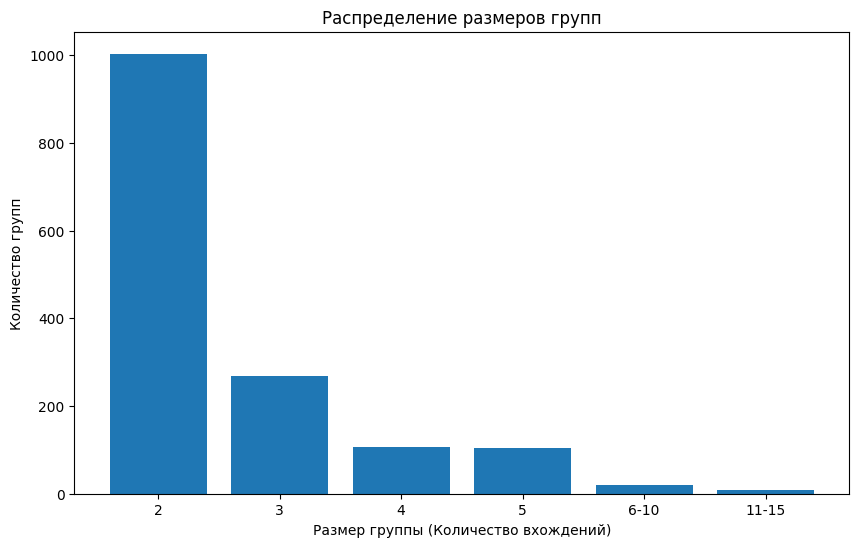

In [ ]:
import matplotlib.pyplot as plt


# Группировка данных по 'group_number' и подсчёт количества вхождений в каждую группу
group_counts = df.groupby('group_number').size()

# Удаление групп размером меньше 2
group_counts = group_counts[group_counts >= 2]

# Определение диапазонов для групп
bins = [2, 3, 4, 5, 10, 15, float('inf')]
labels = ['2', '3', '4', '5', '6-10', '11-15', '16 и больше']

# Создание категорий на основе диапазонов
group_bins = pd.cut(group_counts, bins=bins, labels=labels[:-1], right=False)
group_size_distribution = group_bins.value_counts().sort_index()

# Печать количества групп в каждом диапазоне
print("Количество групп в каждом диапазоне:")
print(group_size_distribution)

# Построение графика распределения размеров групп
plt.figure(figsize=(10, 6))

# Гистограмма распределения
plt.bar(group_size_distribution.index, group_size_distribution.values)

# Подписи к осям и заголовок
plt.xlabel('Размер группы (Количество вхождений)')
plt.ylabel('Количество групп')
plt.title('Распределение размеров групп')

# Отображение графика
plt.show()

In [ ]:
# Проверка на дубликаты по smiles в каждой группе и их удаление
df_no_duplicates = df.drop_duplicates(subset=['group_number', 'smiles'], keep='first')

# Удаление групп размером меньше 2 после удаления дубликатов
group_counts_no_duplicates = df_no_duplicates.groupby('group_number').size()
group_counts_no_duplicates = group_counts_no_duplicates[group_counts_no_duplicates >= 2]
df_no_duplicates = df_no_duplicates[df_no_duplicates['group_number'].isin(group_counts_no_duplicates.index)]

# Печать результатов проверки на дубликаты после удаления
duplicates_per_group_after_removal = df_no_duplicates[df_no_duplicates.duplicated(subset=['group_number', 'smiles'], keep=False)]
print("Дубликаты по smiles в каждой группе после удаления:")
print(duplicates_per_group_after_removal)

Дубликаты по smiles в каждой группе после удаления:
Empty DataFrame
Columns: [Unnamed: 0.1, Unnamed: 0, pdb_code, release_year_x, uniprot_id, protein_name, smiles, murko_scaffold, group_number, num_atoms, resolution, release_year_y, -logKd/Ki, Kd/Ki, value]
Index: []


In [ ]:
df_no_duplicates.to_excel('GeneralV5.xlsx', index=False)

Количество групп в каждом диапазоне:
2        796
3        200
4         75
5         89
6-10      14
11-15      6
Name: count, dtype: int64


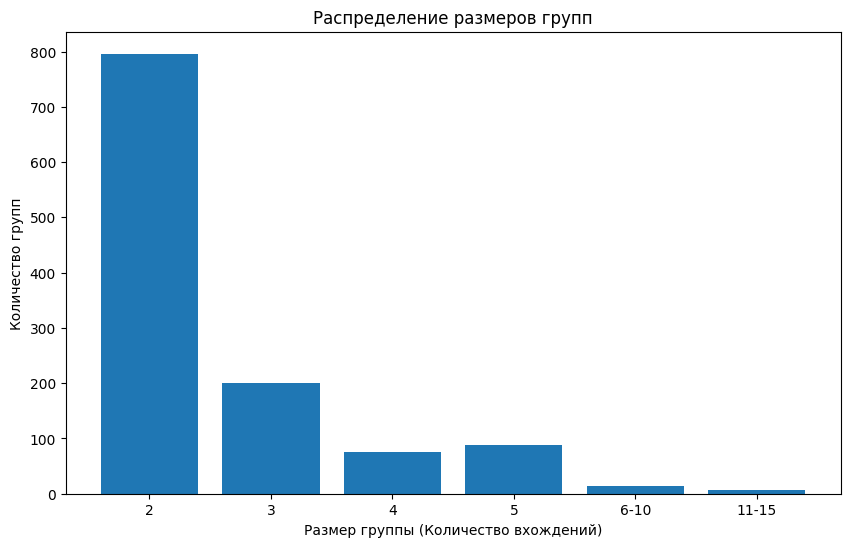

In [ ]:
import matplotlib.pyplot as plt


# Группировка данных по 'group_number' и подсчёт количества вхождений в каждую группу
group_counts = df_no_duplicates.groupby('group_number').size()

# Удаление групп размером меньше 2

# Определение диапазонов для групп
bins = [2, 3, 4, 5, 10, 15, float('inf')]
labels = ['2', '3', '4', '5', '6-10', '11-15', '16 и больше']

# Создание категорий на основе диапазонов
group_bins = pd.cut(group_counts, bins=bins, labels=labels[:-1], right=False)
group_size_distribution = group_bins.value_counts().sort_index()

# Печать количества групп в каждом диапазоне
print("Количество групп в каждом диапазоне:")
print(group_size_distribution)

# Построение графика распределения размеров групп
plt.figure(figsize=(10, 6))

# Гистограмма распределения
plt.bar(group_size_distribution.index, group_size_distribution.values)

# Подписи к осям и заголовок
plt.xlabel('Размер группы (Количество вхождений)')
plt.ylabel('Количество групп')
plt.title('Распределение размеров групп')

# Отображение графика
plt.show()

In [ ]:
import pandas as pd

df = pd.read_excel('GeneralV5.xlsx')

# **Важная часть (обработка форматирования таблицы (активности, знаки соотношения))**

In [ ]:
# Создаем маску для строк, содержащих хотя бы один из символов '<', '>', '~'
mask = df['Kd/Ki'].str.contains(r'[<>~]')

# Извлекаем префикс, знак и значение из строк, соответствующих маске
# Регулярное выражение делит строку на три части: символы до знака, сам знак, и символы после знака
extracted = df[mask]['Kd/Ki'].str.extract(r'(^[^\<\>\~]+)([<>~])(.*)')

# Заменяем в оригинальном DataFrame строки столбца 'Kd/Ki' на извлеченную первую часть (префикс)
df.loc[mask, 'Kd/Ki'] = extracted[0]

# Добавляем новый столбец 'sign', содержащий извлеченные знаки ('<', '>', '~')
df.loc[mask, 'sign'] = extracted[1]

# Заменяем значения в столбце 'value' на извлеченную третью часть
df.loc[mask, 'value'] = extracted[2]

0  1        2
53      Kd  ~     25uM
64      Ki  >     40uM
65      Ki  >     40uM
130   IC50  >    100uM
140   IC50  <  0.001uM
...    ... ..      ...
3078  IC50  >     30uM
3102  IC50  >     30uM
3246    Kd  >    500uM
3247  IC50  >    500uM
3274    Kd  >    180uM

[99 rows x 3 columns]

In [ ]:
df['sign'].fillna('=',inplace=True)

<ipython-input-30-e167f17ec0ab>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sign'].fillna('=',inplace=True)


In [ ]:
df[['numeric_value', 'unit']] = df['value'].str.extract(r'([0-9.]+)([a-zA-Z]+)')

In [ ]:
df.to_excel('GeneralV6.xlsx',index=False)